# USAspending Physical Security Contract Solicitation Analysis

## Table of Contents
1. [Setup](#setup)
2. [Data Preparation](#data-preparation)
3. [Question 1 – How solicitation procedures shifted over time](#question-1)
   - [Aggregated metrics](#question-1-metrics)
   - [Visualisation](#question-1-visualisation)
4. [Question 2 – Award value comparisons by solicitation procedure](#question-2)
   - [Summary statistics](#question-2-summary)
   - [Distribution views](#question-2-visuals)
5. [Key Takeaways](#key-takeaways)


## Setup <a id="setup"></a>
This notebook answers questions from `docs/analysis_plan.md` using only observable USAspending fields.
We track fiscal-year shifts in the mix of `solicitation_procedures` for physical security contracts, focusing on NAICS codes enumerated in `NAICs.md`.

**Value fields referenced throughout**

- `federal_action_obligation` — incremental obligations recorded for the action.
- `base_and_exercised_options_value` — funded base plus exercised options.
- `base_and_all_options_value` — base plus the ceiling for all options.
- `current_total_value_of_award` — running total inclusive of current modifications.
- `potential_total_value_of_award` — potential ceiling after all modifications/options.
- `total_outlayed_amount_for_overall_award` — cumulative outlays reported for the award.

Annualised contract value equals each award value divided by its performance duration in years; we compute it for the base-plus-options and potential totals when both start and end dates are available.

**Outlier filtering**
- Contracts with `base_and_all_options_value` below 0 or above USD 1,000,000,000 are excluded from every analysis cell.

In [1]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path().resolve()
for candidate in (NOTEBOOK_DIR, NOTEBOOK_DIR.parent, NOTEBOOK_DIR.parent.parent):
    if (candidate / 'scripts').exists():
        if str(candidate) not in sys.path:
            sys.path.insert(0, str(candidate))
        break

import pandas as pd
from scripts.usaspending_utils import (
    prepare_solicitation_dataset,
    compute_solicitation_timeseries,
    pivot_solicitation_share,
    prepare_cost_dataset,
    summarize_cost_by_procedure,
)
from scripts.modeling_utils import candidate_feature_columns, extract_linear_feature_importance, train_gradient_boost_model_with_split, train_log_linear_model_with_split, train_decision_tree_model_with_split
from scripts.visualization_utils import plot_competition_value_profile
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display


In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)
import seaborn as sns
sns.set_theme(style='whitegrid')
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12


## Data Preparation <a id="data-preparation"></a>
The dataset pulls prime transactions filtered to the NAICS codes maintained in `NAICs.md` (currently security-guard services).
Only the raw fields required for solicitation analysis are loaded; no derived "quality" scores are created.


In [3]:
solicitation_df = prepare_solicitation_dataset()

records_total = len(solicitation_df)
fiscal_year_min = int(solicitation_df['action_date_fiscal_year'].min())
fiscal_year_max = int(solicitation_df['action_date_fiscal_year'].max())
unique_procedures = solicitation_df['solicitation_procedures'].nunique(dropna=True)
total_obligation = solicitation_df['federal_action_obligation'].sum()

overview = pd.DataFrame(
    {
        'Metric': [
            'Records loaded',
            'Fiscal year coverage',
            'Distinct solicitation procedures',
            'Total federal action obligation (USD billions)',
        ],
        'Value': [
            f"{records_total:,}",
            f"FY{fiscal_year_min} – FY{fiscal_year_max}",
            unique_procedures,
            f"{total_obligation / 1e9:,.1f}",
        ],
    }
)

display(overview)
display(solicitation_df.head())


# Remove extreme total values (<0 or >$1B)
base_values = solicitation_df["base_and_all_options_value"]
between_mask = base_values.between(0, 1_000_000_000, inclusive="both")
mask = between_mask.fillna(False) | base_values.isna()
solicitation_outliers_removed = (~mask).sum()
solicitation_df = solicitation_df[mask]


,Metric,Value
0,Records loaded,"220,528"
1,Fiscal year coverage,FY2008 – FY2026
2,Distinct solicitation procedures,9
3,Total federal action obligation (USD billions),72.5


,action_date_fiscal_year,solicitation_procedures,federal_action_obligation,base_and_exercised_options_value,base_and_all_options_value,current_total_value_of_award,potential_total_value_of_award,total_outlayed_amount_for_overall_award,extent_competed,number_of_offers_received
0,2025,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,0.00,NaN,0.00,NaN,"39,453,945.58",NaN,FULL AND OPEN COMPETITION,2.00
1,2025,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,0.00,NaN,"737,962.78",NaN,"40,191,908.36",NaN,FULL AND OPEN COMPETITION,2.00
2,2013,NEGOTIATED PROPOSAL/QUOTE,"256,345.56",0.00,"256,345.56",NaN,NaN,NaN,FULL AND OPEN COMPETITION,1.00
3,2014,NEGOTIATED PROPOSAL/QUOTE,"245,300.00",0.00,"245,300.00",NaN,NaN,NaN,FULL AND OPEN COMPETITION,1.00
4,2019,SIMPLIFIED ACQUISITION,"10,941.60","10,941.60","10,941.60","10,941.60","10,941.60",NaN,COMPETED UNDER SAP,1.00


The pull contains every prime transaction in the filtered database where the NAICS code matches the security-guard segment. The head preview confirms that only observable solicitation attributes are used for subsequent group-bys.

## Question 1 – How solicitation procedures shifted over time <a id="question-1"></a>
We examine the distribution of `solicitation_procedures` by fiscal year and report both award counts and obligations.
Optional context on competition intensity comes from `number_of_offers_received`."


### Aggregated metrics <a id="question-1-metrics"></a>

In [4]:
timeseries = compute_solicitation_timeseries(solicitation_df)
# Exclude future fiscal years with partial reporting (>= 2026)
cutoff_year = 2025
timeseries_clean = timeseries[timeseries['action_date_fiscal_year'] <= cutoff_year].copy()

# Compute shares for readability
timeseries_clean['awards_share'] = timeseries_clean.groupby('action_date_fiscal_year')['awards_total'].transform(lambda x: x / x.sum())
timeseries_clean['obligation_share'] = timeseries_clean.groupby('action_date_fiscal_year')['obligation_total'].transform(lambda x: x / x.sum())

# Snapshot of the most recent full fiscal year
def format_snapshot(df, year):
    snapshot = df[df['action_date_fiscal_year'] == year].copy()
    snapshot = snapshot.sort_values('awards_total', ascending=False)
    snapshot['awards_share_pct'] = snapshot['awards_share'] * 100
    snapshot['obligation_share_pct'] = snapshot['obligation_share'] * 100
    snapshot['obligation_total_bil'] = snapshot['obligation_total'] / 1e9
    cols = [
        'solicitation_procedures',
        'awards_total',
        'awards_share_pct',
        'obligation_total_bil',
        'obligation_share_pct',
        'median_offers',
    ]
    return snapshot[cols].round(
        {
            'awards_share_pct': 1,
            'obligation_total_bil': 2,
            'obligation_share_pct': 1,
            'median_offers': 1,
        }
    )

latest_year = timeseries_clean['action_date_fiscal_year'].max()
latest_snapshot = format_snapshot(timeseries_clean, latest_year)

overall_summary = (
    timeseries_clean.groupby('solicitation_procedures')
    .agg(
        awards_total=('awards_total', 'sum'),
        obligation_total=('obligation_total', 'sum'),
        median_offers=('median_offers', 'median'),
    )
    .assign(
        awards_share=lambda df: df['awards_total'] / df['awards_total'].sum(),
        obligation_share=lambda df: df['obligation_total'] / df['obligation_total'].sum(),
        obligation_total_bil=lambda df: df['obligation_total'] / 1e9,
    )
    .sort_values('awards_total', ascending=False)
    .round(
        {
            'median_offers': 1,
            'awards_share': 3,
            'obligation_share': 3,
            'obligation_total_bil': 2,
        }
    )
)

print(f"Latest completed fiscal year: FY{latest_year}")
display(latest_snapshot)
print("\nAggregate FY2008–FY2025 totals by solicitation procedure")
display(overall_summary)

Latest completed fiscal year: FY2025


,solicitation_procedures,awards_total,awards_share_pct,obligation_total_bil,obligation_share_pct,median_offers
126,NEGOTIATED PROPOSAL/QUOTE,5534,49.40,3.68,65.70,10.00
129,SIMPLIFIED ACQUISITION,3903,34.80,0.13,2.30,1.00
130,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,1448,12.90,1.45,25.80,3.00
127,ONLY ONE SOURCE,303,2.70,0.31,5.60,1.00
125,,13,0.10,0.00,0.00,NaN
128,SEALED BID,7,0.10,0.03,0.50,3.00
131,TWO STEP,3,0.00,0.00,0.00,3.00



Aggregate FY2008–FY2025 totals by solicitation procedure


,awards_total,obligation_total,median_offers,awards_share,obligation_share,obligation_total_bil
solicitation_procedures,,,,,,
NEGOTIATED PROPOSAL/QUOTE,94083,"46,018,648,694.71",5.50,0.51,0.63,46.02
SIMPLIFIED ACQUISITION,51267,"1,960,626,472.54",1.00,0.28,0.03,1.96
SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,22034,"19,145,844,695.02",3.00,0.12,0.26,19.15
ONLY ONE SOURCE,12937,"4,554,215,458.33",1.00,0.07,0.06,4.55
,2837,"984,101,911.46",21.00,0.01,0.01,0.98
SEALED BID,521,"514,168,963.98",4.00,0.00,0.01,0.51
ALTERNATIVE SOURCES,295,"102,361,215.45",6.00,0.00,0.00,0.10
TWO STEP,39,"16,755,752.24",5.00,0.00,0.00,0.02
BASIC RESEARCH,6,"927,383.21",1.00,0.00,0.00,0.00


Negotiated proposal procedures dominate across the entire period, while simplified acquisition and fair-opportunity orders account for sizeable minorities. The median number of offers is materially higher for fully negotiated procurements than for simplified transactions.

### Visualisation <a id="question-1-visualisation"></a>

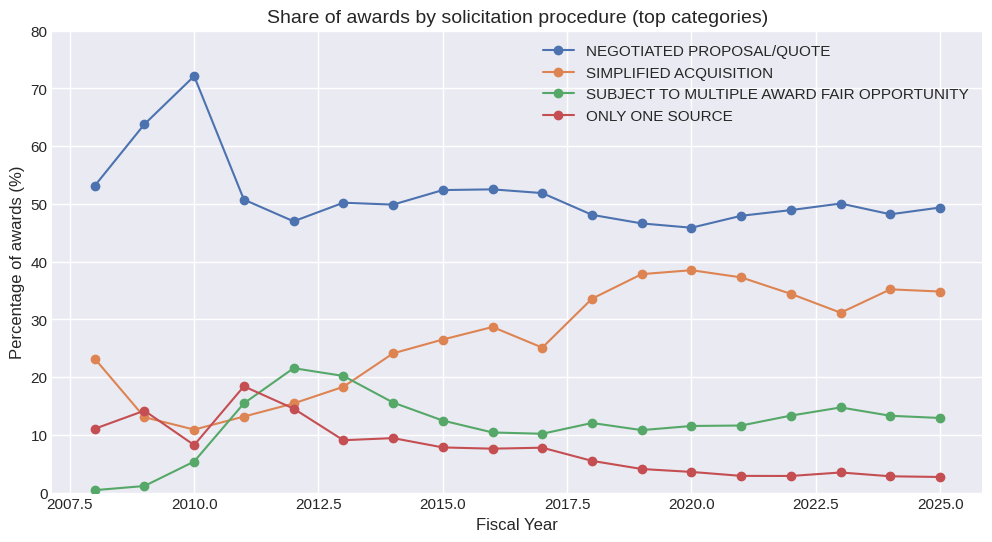

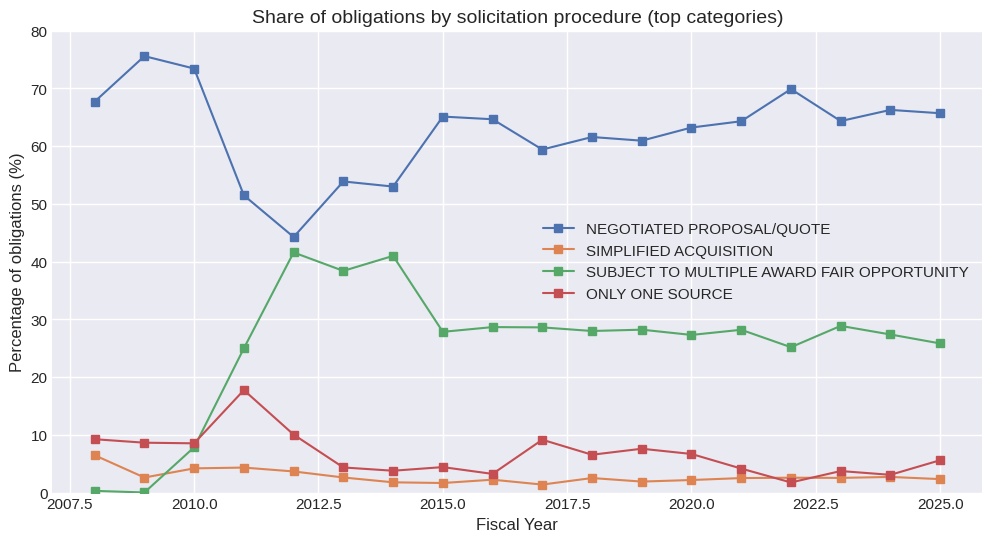

In [5]:
share_awards = pivot_solicitation_share(timeseries_clean)
top_labels = timeseries_clean.groupby('solicitation_procedures')['awards_total'].sum().nlargest(4).index

fig, ax = plt.subplots()
for label in top_labels:
    ax.plot(
        share_awards.index,
        share_awards[label] * 100,
        marker='o',
        label=label.title() if label.islower() else label,
    )

ax.set_title('Share of awards by solicitation procedure (top categories)')
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Percentage of awards (%)')
ax.set_ylim(0, 80)
ax.legend()
plt.show()

# Obligation share plot
share_obligation = (
    timeseries_clean.assign(
        total_obligation=timeseries_clean.groupby('action_date_fiscal_year')['obligation_total'].transform('sum')
    )
    .assign(obligation_share=lambda df: df['obligation_total'] / df['total_obligation'])
    .pivot_table(
        index='action_date_fiscal_year',
        columns='solicitation_procedures',
        values='obligation_share',
        fill_value=0.0,
    )
)

fig, ax = plt.subplots()
for label in top_labels:
    ax.plot(
        share_obligation.index,
        share_obligation[label] * 100,
        marker='s',
        label=label.title() if label.islower() else label,
    )

ax.set_title('Share of obligations by solicitation procedure (top categories)')
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Percentage of obligations (%)')
ax.set_ylim(0, 80)
ax.legend()
plt.show()


Both charts show negotiated procedures holding the largest share of awards and obligations, with simplified acquisitions gaining ground during the mid-2010s before receding. Fair-opportunity orders maintain a stable mid-range share, underscoring the continued use of multiple-award IDV vehicles for guard services.

## Question 2 – Award value comparisons by solicitation procedure <a id="question-2"></a>
This step follows the updated `analysis_plan.md`: instead of inferring latent "quality", we stratify observed award values and annualised amounts by `solicitation_procedures`.

### Summary statistics <a id="question-2-summary"></a>
The table below reports medians and interquartile ranges using only positive observations for each value field. Amounts are expressed in millions of USD to aid readability.

In [6]:
cost_df = prepare_cost_dataset()

value_fields = [
    ('federal_action_obligation', 'Federal action obligation'),
    ('base_and_all_options_value', 'Base + all options value'),
    ('potential_total_value_of_award', 'Potential total value'),
    ('total_outlayed_amount_for_overall_award', 'Total outlayed amount'),
]

annualized_fields = [
    ('annualized_base_all', 'Annualised base + all options'),
    ('annualized_potential_total', 'Annualised potential total'),
]

def summarise_positive(df, fields):
    records = []
    for label, group in df.groupby('solicitation_procedures', dropna=False):
        display_label = label if isinstance(label, str) and label.strip() else 'UNSPECIFIED'
        record = {'Solicitation procedure': display_label, 'Awards': len(group)}
        for field, title in fields:
            series = group[field].dropna()
            series = series[series > 0]
            if series.empty:
                record[f'{title} median'] = pd.NA
                record[f'{title} iqr_low'] = pd.NA
                record[f'{title} iqr_high'] = pd.NA
            else:
                record[f'{title} median'] = series.median()
                record[f'{title} iqr_low'] = series.quantile(0.25)
                record[f'{title} iqr_high'] = series.quantile(0.75)
        records.append(record)
    summary = pd.DataFrame(records).sort_values('Awards', ascending=False)
    return summary

value_summary_raw = summarise_positive(cost_df, value_fields)
annualized_summary_raw = summarise_positive(cost_df, annualized_fields)

millions = 1e6

def format_tables(summary, fields):
    table = summary.copy()
    for field, title in fields:
        median_col = f'{title} median'
        iqr_low_col = f'{title} iqr_low'
        iqr_high_col = f'{title} iqr_high'
        table[f'{title} median (USD millions)'] = table[median_col] / millions
        table[f'{title} IQR (USD millions)'] = table.apply(
            lambda row: (
                f"{row[iqr_low_col] / millions:,.1f} – {row[iqr_high_col] / millions:,.1f}"
                if pd.notna(row[iqr_low_col]) and pd.notna(row[iqr_high_col])
                else 'n/a'
            ),
            axis=1,
        )
        table.drop(columns=[median_col, iqr_low_col, iqr_high_col], inplace=True)
    return table

value_summary = format_tables(value_summary_raw, value_fields)
annualized_summary = format_tables(annualized_summary_raw, annualized_fields)

pd.set_option('display.max_rows', None)
display(value_summary.reset_index(drop=True))
display(annualized_summary.reset_index(drop=True))


base_values_cost = cost_df["base_and_all_options_value"]
between_mask_cost = base_values_cost.between(0, 1_000_000_000, inclusive="both")
mask_cost = between_mask_cost.fillna(False) | base_values_cost.isna()
cost_outliers_removed = (~mask_cost).sum()
cost_df = cost_df[mask_cost]


,Solicitation procedure,Awards,Federal action obligation median (USD millions),Federal action obligation IQR (USD millions),Base + all options value median (USD millions),Base + all options value IQR (USD millions),Potential total value median (USD millions),Potential total value IQR (USD millions),Total outlayed amount median (USD millions),Total outlayed amount IQR (USD millions)
0,NEGOTIATED PROPOSAL/QUOTE,105873,0.09,0.0 – 0.6,0.07,0.0 – 0.7,5.72,1.5 – 22.7,2.75,0.6 – 7.9
1,SIMPLIFIED ACQUISITION,69314,0.02,0.0 – 0.0,0.02,0.0 – 0.0,0.02,0.0 – 0.0,0.00,0.0 – 0.0
2,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,26292,0.13,0.0 – 0.6,0.09,0.0 – 0.5,3.45,0.4 – 15.6,2.65,0.3 – 12.6
3,ONLY ONE SOURCE,14994,0.03,0.0 – 0.2,0.02,0.0 – 0.3,0.96,0.0 – 6.7,0.57,0.1 – 2.5
4,UNSPECIFIED,3069,0.06,0.0 – 0.4,0.07,0.0 – 0.5,29.87,4.4 – 324.1,2.59,0.5 – 2.6
5,SEALED BID,604,0.23,0.0 – 1.7,0.17,0.0 – 1.7,34.54,4.4 – 55.8,<NA>,n/a
6,ALTERNATIVE SOURCES,334,0.03,0.0 – 0.2,0.03,0.0 – 0.2,62.15,1.7 – 74.9,1.21,1.2 – 1.2
7,TWO STEP,39,0.34,0.1 – 0.5,0.23,0.1 – 0.3,10.81,10.8 – 11.0,10.99,11.0 – 11.0
8,BASIC RESEARCH,9,0.14,0.1 – 0.3,0.14,0.1 – 0.3,1.32,1.3 – 1.3,<NA>,n/a


,Solicitation procedure,Awards,Annualised base + all options median (USD millions),Annualised base + all options IQR (USD millions),Annualised potential total median (USD millions),Annualised potential total IQR (USD millions)
0,NEGOTIATED PROPOSAL/QUOTE,105873,0.15,0.0 – 1.3,5.87,2.2 – 16.0
1,SIMPLIFIED ACQUISITION,69314,0.03,0.0 – 0.1,0.02,0.0 – 0.0
2,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,26292,0.19,0.0 – 1.1,2.78,0.5 – 14.8
3,ONLY ONE SOURCE,14994,0.06,0.0 – 0.8,0.98,0.1 – 6.2
4,UNSPECIFIED,3069,0.31,0.0 – 3.0,17.73,7.6 – 64.3
5,SEALED BID,604,0.41,0.1 – 2.5,13.96,2.2 – 28.0
6,ALTERNATIVE SOURCES,334,0.08,0.0 – 0.3,0.91,0.3 – 2.4
7,TWO STEP,39,0.11,0.1 – 0.2,0.42,0.3 – 0.6
8,BASIC RESEARCH,9,<NA>,n/a,<NA>,n/a


Negotiated proposals still deliver the highest positive medians: their base-plus-options values cluster around USD 0.07 million with an upper quartile near USD 0.65 million, while simplified acquisitions centre on approximately USD 0.02 million. Fair-opportunity task orders sit between the two, combining numerous small orders with a sizeable tail approaching half a million dollars at the 75th percentile.

### Distribution views <a id="question-2-visuals"></a>
Boxplots use a logarithmic y-axis (base 10) to highlight the wide spread in award sizes across solicitation labels.

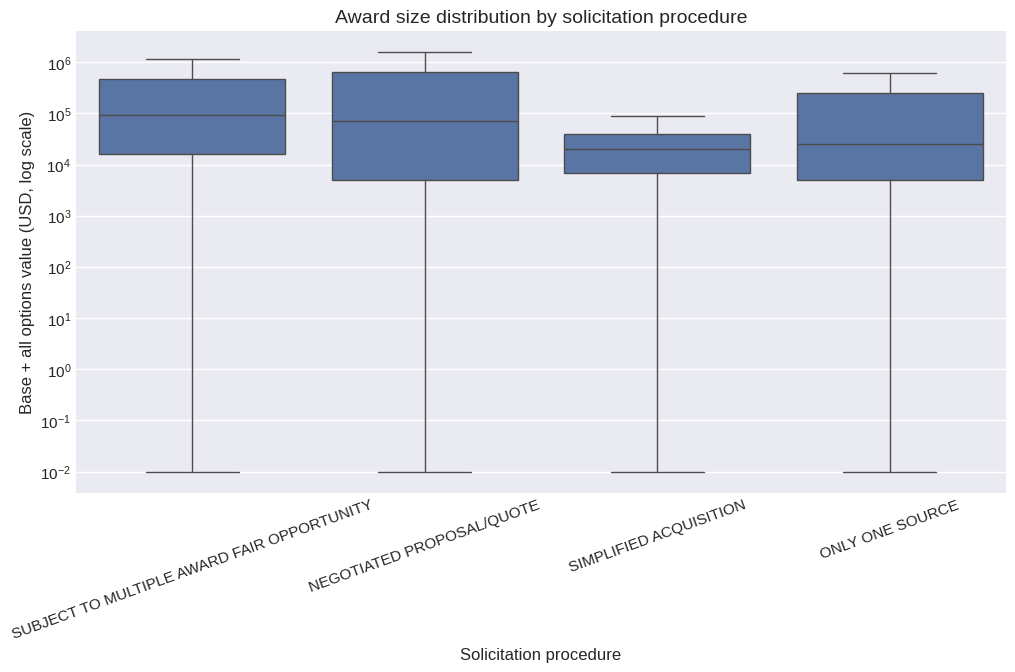

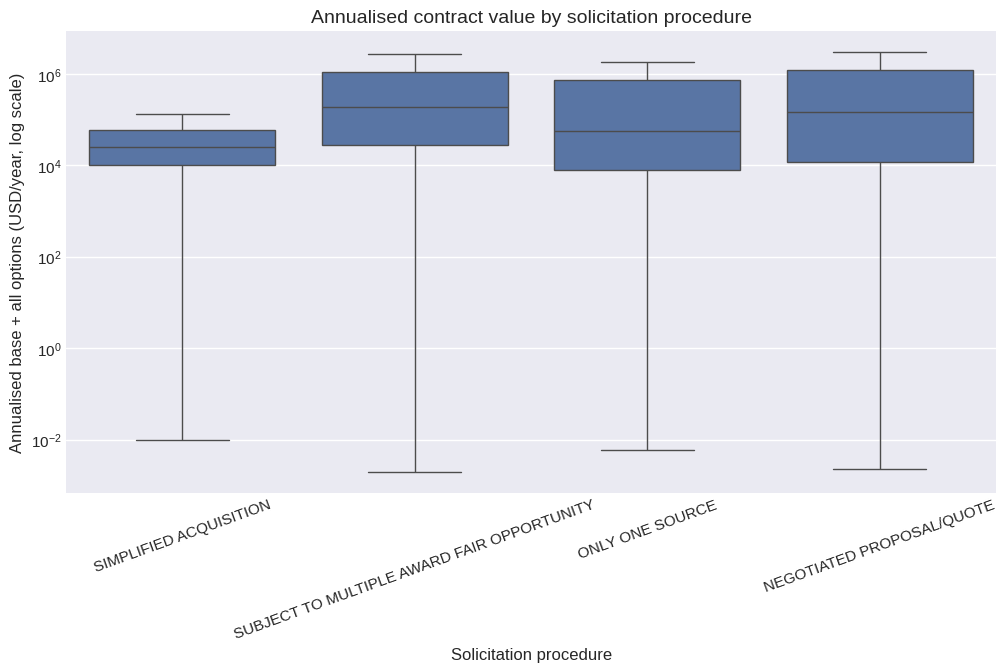

In [7]:
top_labels = value_summary['Solicitation procedure'].head(4)
plot_df = cost_df[
    cost_df['solicitation_procedures'].isin(top_labels)
].copy()
plot_df['solicitation_procedures'] = plot_df['solicitation_procedures'].replace('', 'UNSPECIFIED')

fig, ax = plt.subplots()
sns.boxplot(
    data=plot_df[plot_df['base_and_all_options_value'] > 0],
    x='solicitation_procedures',
    y='base_and_all_options_value',
    showfliers=False,
    ax=ax,
)
ax.set_yscale('log')
ax.set_xlabel('Solicitation procedure')
ax.set_ylabel('Base + all options value (USD, log scale)')
ax.set_title('Award size distribution by solicitation procedure')
plt.xticks(rotation=20)
plt.show()

fig, ax = plt.subplots()
sns.boxplot(
    data=plot_df[plot_df['annualized_base_all'] > 0],
    x='solicitation_procedures',
    y='annualized_base_all',
    showfliers=False,
    ax=ax,
)
ax.set_yscale('log')
ax.set_xlabel('Solicitation procedure')
ax.set_ylabel('Annualised base + all options (USD/year, log scale)')
ax.set_title('Annualised contract value by solicitation procedure')
plt.xticks(rotation=20)
plt.show()


The log-scale boxplots reinforce the skew seen in the tables: negotiated awards reach a median of roughly USD 0.07 million on the base-plus-options metric with a 75th percentile near USD 0.65 million, while simplified acquisitions cluster around USD 0.02 million. Fair-opportunity task orders sit between the two, pairing median obligations around USD 0.13 million with a long upper tail.

#### Comparative distributions
Kernel-density overlays and aligned histograms (log-scaled) make the distance between medians more explicit across solicitation labels.

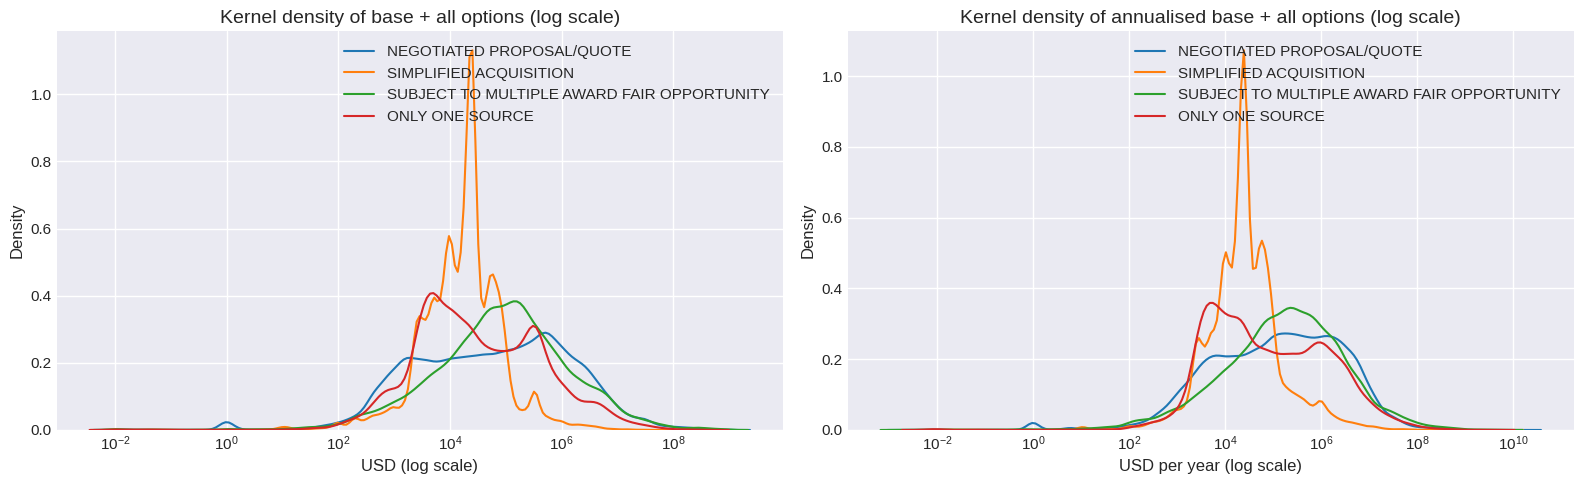

In [8]:
top_labels = value_summary['Solicitation procedure'].head(4)
plot_df = cost_df[cost_df['solicitation_procedures'].isin(top_labels)].copy()
plot_df['solicitation_procedures'] = plot_df['solicitation_procedures'].replace('', 'UNSPECIFIED')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
palette = sns.color_palette('tab10', n_colors=len(top_labels))

for label, color in zip(top_labels, palette):
    label_clean = label if label else 'UNSPECIFIED'
    subset = plot_df[plot_df['solicitation_procedures'] == label_clean]
    sns.kdeplot(
        data=subset[subset['base_and_all_options_value'] > 0],
        x='base_and_all_options_value',
        ax=axes[0],
        label=label_clean,
        log_scale=True,
        bw_adjust=0.8,
        color=color,
    )
    sns.kdeplot(
        data=subset[subset['annualized_base_all'] > 0],
        x='annualized_base_all',
        ax=axes[1],
        label=label_clean,
        log_scale=True,
        bw_adjust=0.8,
        color=color,
    )

axes[0].set_title('Kernel density of base + all options (log scale)')
axes[0].set_xlabel('USD (log scale)')
axes[0].set_ylabel('Density')
axes[1].set_title('Kernel density of annualised base + all options (log scale)')
axes[1].set_xlabel('USD per year (log scale)')
axes[1].set_ylabel('Density')
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()


#### Median distance comparison
Percentage deltas are computed relative to negotiated proposal medians to highlight the pricing gap across solicitation labels.

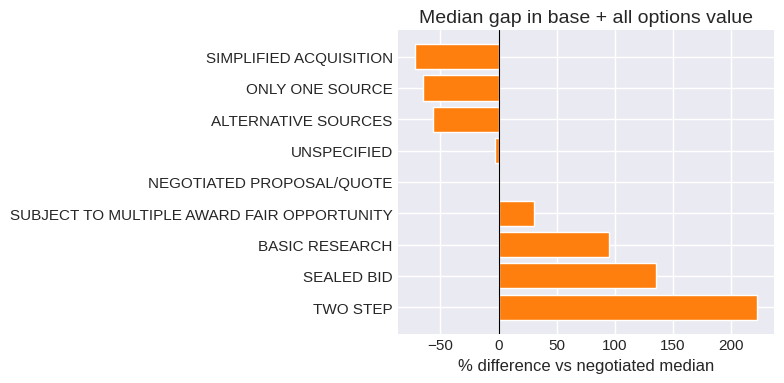

,Solicitation procedure,median_delta_pct
8,TWO STEP,222.08
5,SEALED BID,135.38
2,BASIC RESEARCH,94.84
7,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,30.60
3,NEGOTIATED PROPOSAL/QUOTE,0.00
0,UNSPECIFIED,-2.65
1,ALTERNATIVE SOURCES,-55.98
4,ONLY ONE SOURCE,-65.22
6,SIMPLIFIED ACQUISITION,-72.10


In [9]:
median_table = value_summary_raw[['Solicitation procedure', 'Base + all options value median']].copy()
median_table.rename(columns={'Base + all options value median': 'median_value'}, inplace=True)
median_table = median_table.dropna(subset=['median_value'])
median_table = median_table[median_table['median_value'] > 0]

reference_value = median_table.loc[
    median_table['Solicitation procedure'] == 'NEGOTIATED PROPOSAL/QUOTE',
    'median_value'
].iloc[0]

median_table['median_delta_pct'] = (median_table['median_value'] / reference_value - 1) * 100
median_table = median_table.sort_values('median_value', ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
colors = []
for proc in median_table['Solicitation procedure']:
    if proc == 'NEGOTIATED PROPOSAL/QUOTE':
        colors.append('#1f77b4')
    else:
        colors.append('#ff7f0e')
ax.barh(median_table['Solicitation procedure'], median_table['median_delta_pct'], color=colors)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('% difference vs negotiated median')
ax.set_title('Median gap in base + all options value')
plt.tight_layout()
plt.show()

median_table[['Solicitation procedure', 'median_delta_pct']]


### Focused comparison – Negotiated vs Simplified acquisitions <a id="question-2-focused"></a>
The following views isolate `NEGOTIATED PROPOSAL/QUOTE` and `SIMPLIFIED ACQUISITION` to highlight cost differences under Question 2.

In [10]:
focus_labels = ['NEGOTIATED PROPOSAL/QUOTE', 'SIMPLIFIED ACQUISITION']
focus_df = cost_df[cost_df['solicitation_procedures'].isin(focus_labels)].copy()
# Exclude contracts longer than 20 years (retain NaN durations for completeness)
focus_df = focus_df[focus_df['performance_years'].isna() | ((focus_df['performance_years'] >= 0) & (focus_df['performance_years'] <= 20))]
# Enforce value bounds: drop base values outside (0, 1B]
base_mask = focus_df['base_and_all_options_value'].between(1, 1_000_000_000, inclusive='both')
focus_df = focus_df[base_mask]
# Recalculate annualised column mask (remove non-positive)
focus_df = focus_df[focus_df['annualized_base_all'] > 0]
focus_df = focus_df.assign(
    base_all_millions=focus_df['base_and_all_options_value'] / 1e6,
    annualized_base_all_millions=focus_df['annualized_base_all'] / 1e6,
    federal_obligation_millions=focus_df['federal_action_obligation'] / 1e6,
)

focus_df['log_base_all'] = np.log10(focus_df['base_and_all_options_value'])
focus_df['log_annualized_base_all'] = np.log10(focus_df['annualized_base_all'])
focus_df['log_federal_obligation'] = np.log10(focus_df['federal_action_obligation'].where(focus_df['federal_action_obligation'] > 0))


#### Distribution profiles
Two violin plots show how negotiated awards dominate larger values even when scaled to millions of dollars.

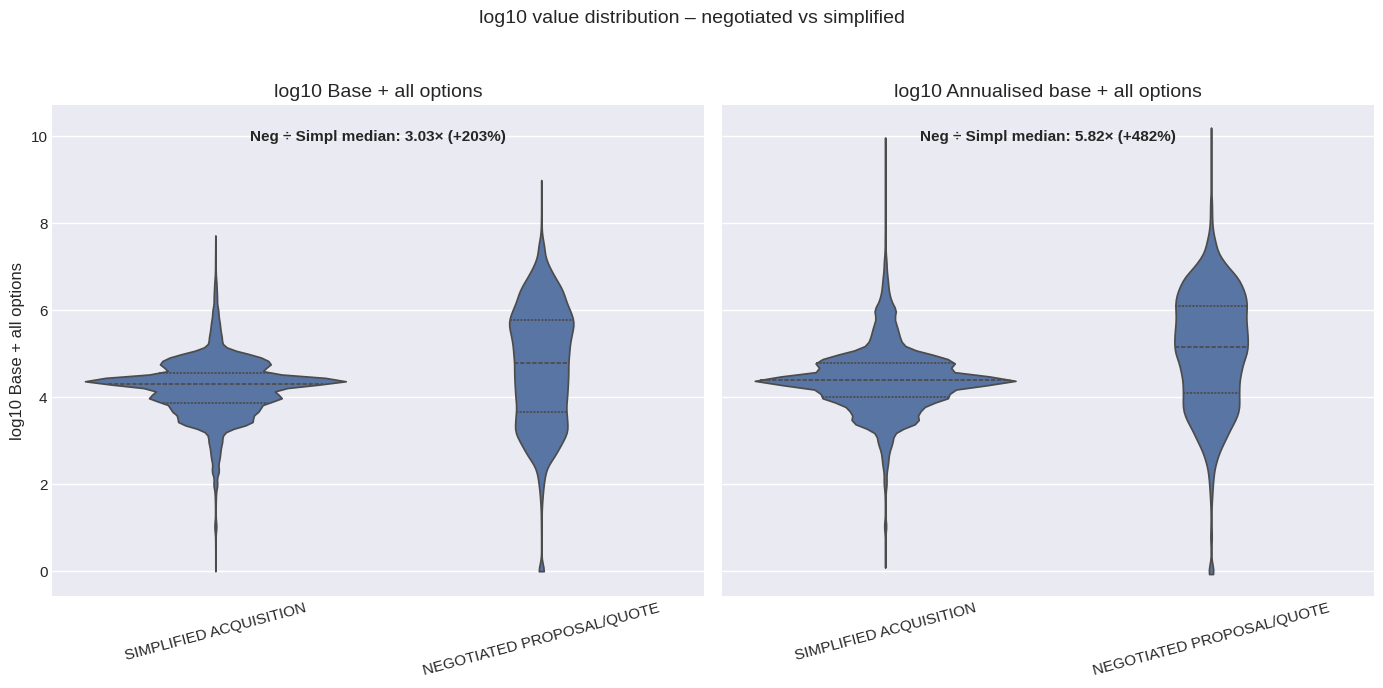

In [11]:
melt_violin = focus_df[['solicitation_procedures', 'log_base_all', 'log_annualized_base_all']].dropna().melt(
    id_vars='solicitation_procedures',
    var_name='metric',
    value_name='log_value'
)
metric_map = {
    'log_base_all': 'log10 Base + all options',
    'log_annualized_base_all': 'log10 Annualised base + all options',
}
melt_violin['metric'] = melt_violin['metric'].map(metric_map)

fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
for ax, metric in zip(axes, metric_map.values()):
    subset = melt_violin[melt_violin['metric'] == metric]
    sns.violinplot(data=subset, x='solicitation_procedures', y='log_value', ax=ax, inner='quartile', cut=0)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_title(metric)
    ax.tick_params(axis='x', rotation=15)

median_values = focus_df.groupby('solicitation_procedures')[['base_and_all_options_value', 'annualized_base_all']].median()
ratio_base = median_values.loc['NEGOTIATED PROPOSAL/QUOTE', 'base_and_all_options_value'] / median_values.loc['SIMPLIFIED ACQUISITION', 'base_and_all_options_value']
ratio_ann = median_values.loc['NEGOTIATED PROPOSAL/QUOTE', 'annualized_base_all'] / median_values.loc['SIMPLIFIED ACQUISITION', 'annualized_base_all']

axes[0].annotate(
    f"Neg ÷ Simpl median: {ratio_base:.2f}× ({(ratio_base-1)*100:+.0f}%)",
    xy=(0.5, 0.95), xycoords='axes fraction', ha='center', va='top', fontsize=11, fontweight='bold'
)
axes[1].annotate(
    f"Neg ÷ Simpl median: {ratio_ann:.2f}× ({(ratio_ann-1)*100:+.0f}%)",
    xy=(0.5, 0.95), xycoords='axes fraction', ha='center', va='top', fontsize=11, fontweight='bold'
)

plt.suptitle('log10 value distribution – negotiated vs simplified', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Median comparison (log-scaled bars)\nGrouped bars on a log axis highlight how negotiated medians dwarf simplified awards across key value fields.

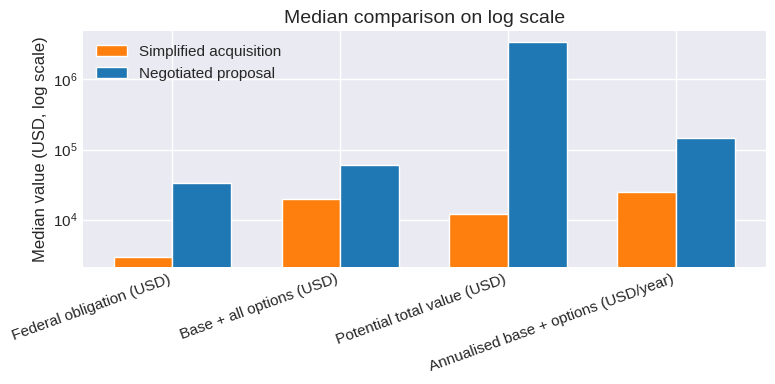

In [12]:
metrics = {
    'federal_action_obligation': 'Federal obligation (USD)',
    'base_and_all_options_value': 'Base + all options (USD)',
    'potential_total_value_of_award': 'Potential total value (USD)',
    'annualized_base_all': 'Annualised base + options (USD/year)',
}
records = []
for field, label in metrics.items():
    medians = focus_df.groupby('solicitation_procedures')[field].median()
    simplified = medians.get('SIMPLIFIED ACQUISITION')
    negotiated = medians.get('NEGOTIATED PROPOSAL/QUOTE')
    if simplified is not None and negotiated is not None and simplified > 0 and negotiated > 0:
        records.append({
            'Metric': label,
            'Simplified': simplified,
            'Negotiated': negotiated,
        })
median_df = pd.DataFrame(records)

fig, ax = plt.subplots(figsize=(8, 4))
idx = np.arange(len(median_df))
width = 0.35
ax.bar(idx - width/2, median_df['Simplified'], width, label='Simplified acquisition', color='#ff7f0e')
ax.bar(idx + width/2, median_df['Negotiated'], width, label='Negotiated proposal', color='#1f77b4')
ax.set_xticks(idx)
ax.set_xticklabels(median_df['Metric'], rotation=20, ha='right')
ax.set_yscale('log')
ax.set_ylabel('Median value (USD, log scale)')
ax.set_title('Median comparison on log scale')
ax.legend()
plt.tight_layout()
plt.show()


#### Median ratios
Ratios greater than 1 indicate how many times higher negotiated medians are relative to simplified awards.

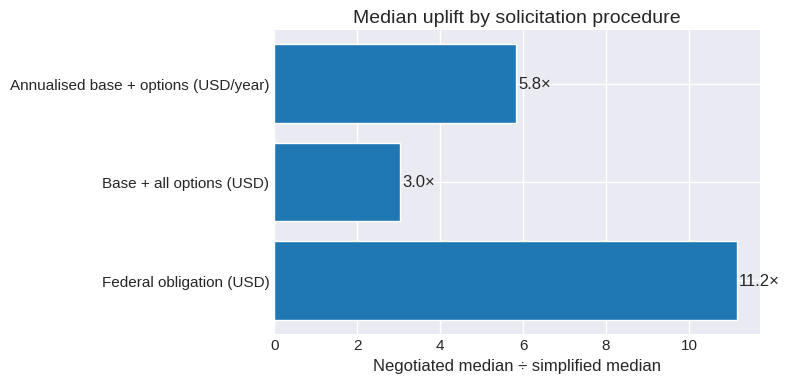

In [13]:
ratio_metrics = {
    'federal_action_obligation': 'Federal obligation (USD)',
    'base_and_all_options_value': 'Base + all options (USD)',
    'annualized_base_all': 'Annualised base + options (USD/year)',
}
ratio_records = []
for field, label in ratio_metrics.items():
    medians = focus_df.groupby('solicitation_procedures')[field].median()
    simplified = medians.get('SIMPLIFIED ACQUISITION')
    negotiated = medians.get('NEGOTIATED PROPOSAL/QUOTE')
    if simplified and negotiated:
        ratio_records.append({'Metric': label, 'Ratio': negotiated / simplified})
ratio_df = pd.DataFrame(ratio_records)

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(ratio_df['Metric'], ratio_df['Ratio'], color='#1f77b4')
for i, val in enumerate(ratio_df['Ratio']):
    ax.text(val + 0.05, i, f"{val:.1f}×", va='center')
ax.set_xlabel('Negotiated median ÷ simplified median')
ax.set_title('Median uplift by solicitation procedure')
plt.tight_layout()
plt.show()


#### Share above value thresholds
Cumulative shares reveal how often each procedure produces higher-value awards.

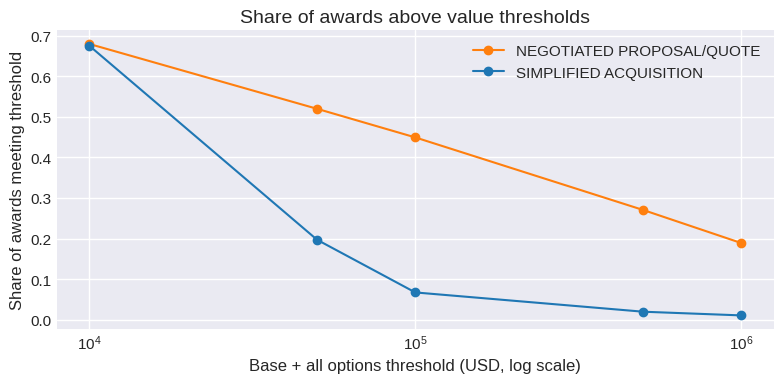

In [14]:
thresholds = [1e4, 5e4, 1e5, 5e5, 1e6]
rows = []
for label in focus_labels:
    subset = focus_df[focus_df['solicitation_procedures'] == label]['base_and_all_options_value']
    total = len(subset)
    for threshold in thresholds:
        share = (subset >= threshold).mean() if total else np.nan
        rows.append({'Solicitation': label, 'Threshold': threshold, 'Share': share})
cdf_df = pd.DataFrame(rows)

fig, ax = plt.subplots(figsize=(8, 4))
for label, color in zip(focus_labels, ['#ff7f0e', '#1f77b4']):
    series = cdf_df[cdf_df['Solicitation'] == label]
    ax.plot(series['Threshold'], series['Share'], marker='o', label=label, color=color)
ax.set_xscale('log')
ax.set_xlabel('Base + all options threshold (USD, log scale)')
ax.set_ylabel('Share of awards meeting threshold')
ax.set_title('Share of awards above value thresholds')
ax.legend()
plt.tight_layout()
plt.show()


#### Duration and annualised spend bands
Stacked bars show the share of awards belonging to duration buckets and annualised spend buckets, offering a cleaner comparison between negotiated and simplified procedures.

/tmp/ipykernel_163674/2300114821.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['solicitation_procedures', field])
/tmp/ipykernel_163674/2300114821.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['solicitation_procedures', field])


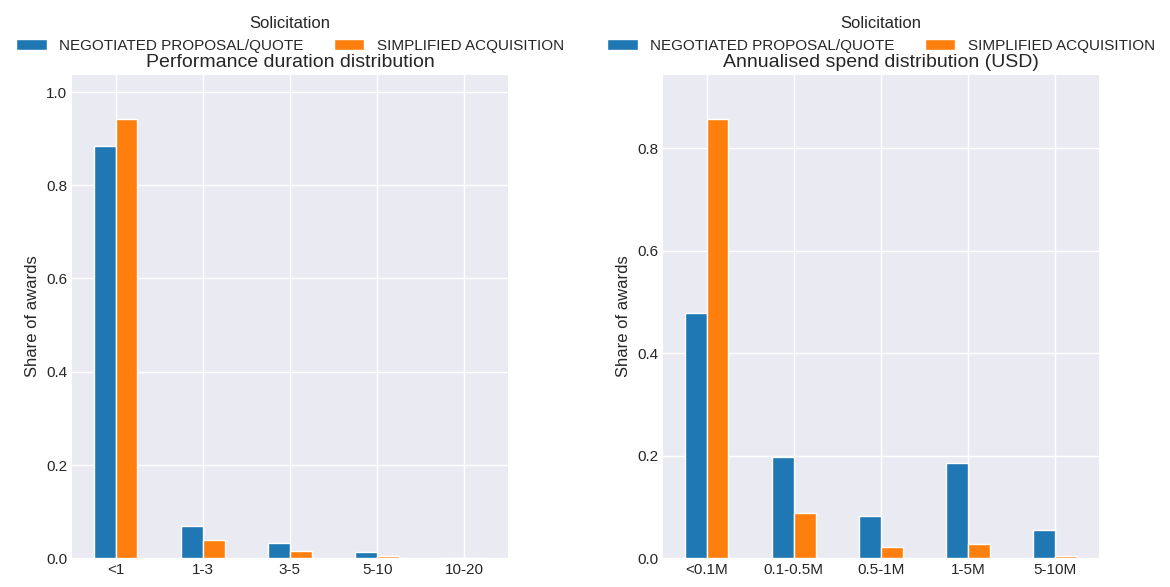

In [15]:
duration_bins = [0, 1, 3, 5, 10, 20]
annual_bins = [0, 0.1e6, 0.5e6, 1e6, 5e6, 10e6]
bucketed = focus_df.copy()
bucketed['duration_bucket'] = pd.cut(bucketed['performance_years'], bins=duration_bins, labels=['<1', '1-3', '3-5', '5-10', '10-20'], include_lowest=True)
bucketed['annual_bucket'] = pd.cut(bucketed['annualized_base_all'], bins=annual_bins, labels=['<0.1M', '0.1-0.5M', '0.5-1M', '1-5M', '5-10M'], include_lowest=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
colors = {'NEGOTIATED PROPOSAL/QUOTE': '#1f77b4', 'SIMPLIFIED ACQUISITION': '#ff7f0e'}

for ax, field, title in zip(
    axes,
    ['duration_bucket', 'annual_bucket'],
    ['Performance duration distribution', 'Annualised spend distribution (USD)']
):
    share = (
        bucketed.dropna(subset=[field])
        .groupby(['solicitation_procedures', field])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .unstack(fill_value=0)
    )
    if isinstance(share.index, pd.MultiIndex):
        share.index = share.index.droplevel(0)
    share = share.reindex(index=colors.keys()).fillna(0).T
    share.plot(kind='bar', ax=ax, color=list(colors.values()))
    ax.set_ylabel('Share of awards')
    ax.set_xlabel('')
    ax.set_title(title)
    ax.legend(title='Solicitation', bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2)
    ax.tick_params(axis='x', rotation=0)
    max_val = share.values.max() if share.values.size else 0
    ax.set_ylim(0, max(max_val * 1.1, 0.05))

plt.tight_layout()
plt.show()


## Question 3 – Does including quality add extra cost? <a id="question-3"></a>
We compare annualised contract values across solicitation procedures of interest, focusing on the negotiated versus simplified acquisition contrast while accounting for pricing structure, competition, and duration.

In [16]:
q3_df = cost_df.copy()
value_mask = q3_df['base_and_all_options_value'].between(1, 1_000_000_000, inclusive='both')
annual_mask = q3_df['annualized_base_all'] > 0
perf_mask = q3_df['performance_years'] > 0
procedure_mask = q3_df['solicitation_procedures'].isin(['NEGOTIATED PROPOSAL/QUOTE', 'SIMPLIFIED ACQUISITION'])
q3_df = q3_df[value_mask & annual_mask & perf_mask & procedure_mask].copy()

q3_df['log_annualized'] = np.log10(q3_df['annualized_base_all'])
q3_df['competition_bucket'] = pd.cut(
    q3_df['number_of_offers_received'].fillna(0),
    bins=[-0.1, 1, 3, 5, 10, q3_df['number_of_offers_received'].max()],
    labels=['1 offer', '2-3', '4-5', '6-10', '11+']
)
q3_df['duration_bucket'] = pd.cut(
    q3_df['performance_years'],
    bins=[0, 1, 3, 5, 10, 20],
    labels=['≤1', '1-3', '3-5', '5-10', '10-20'],
    include_lowest=True
)

print(q3_df[['solicitation_procedures','annualized_base_all','performance_years']].describe(include='all'))


          solicitation_procedures  annualized_base_all  performance_years
count                       77904            77,904.00          77,904.00
unique                          2                  NaN                NaN
top     NEGOTIATED PROPOSAL/QUOTE                  NaN                NaN
freq                        46462                  NaN                NaN
mean                          NaN         3,198,047.36               0.83
std                           NaN       112,432,095.32               0.96
min                           NaN                 0.86               0.00
25%                           NaN            10,507.19               0.32
50%                           NaN            47,383.27               0.83
75%                           NaN           419,173.09               1.00
max                           NaN    15,863,462,024.35              91.00


### Median annualised value by pricing and competition
The heatmap below shows median annualised spend (USD millions/year) by pricing mechanism for negotiated versus simplified acquisitions.

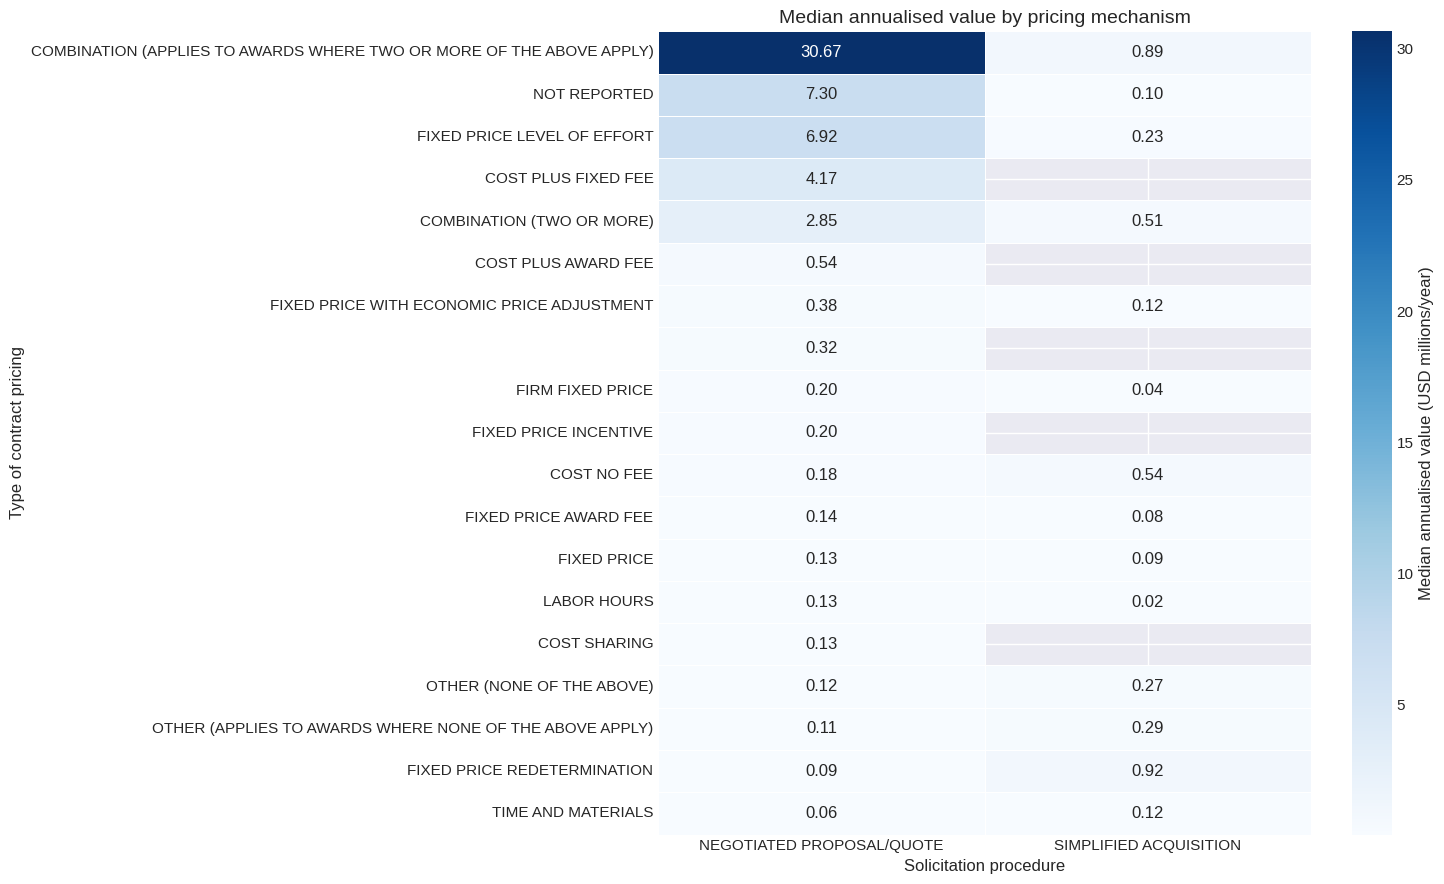

In [17]:
pricing_pivot = (
    q3_df.groupby(['type_of_contract_pricing', 'solicitation_procedures'])['annualized_base_all']
    .median()
    .unstack()
)
pricing_heatmap = (pricing_pivot / 1e6).replace(0, np.nan)
ordering = pricing_heatmap.sort_values(by='NEGOTIATED PROPOSAL/QUOTE', ascending=False).index
pricing_heatmap = pricing_heatmap.loc[ordering]
plt.figure(figsize=(15, 9))
sns.heatmap(
    pricing_heatmap,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    linewidths=0.5,
    cbar_kws={'label': 'Median annualised value (USD millions/year)'}
)
plt.ylabel('Type of contract pricing')
plt.xlabel('Solicitation procedure')
plt.title('Median annualised value by pricing mechanism')
plt.tight_layout()
plt.show()


### Competition intensity versus annualised value
Boxplots (with jittered samples) highlight how higher annualised spend concentrates in buckets with one to three offers, particularly for negotiated awards. The bars underneath show the volume of awards in each competition bucket.


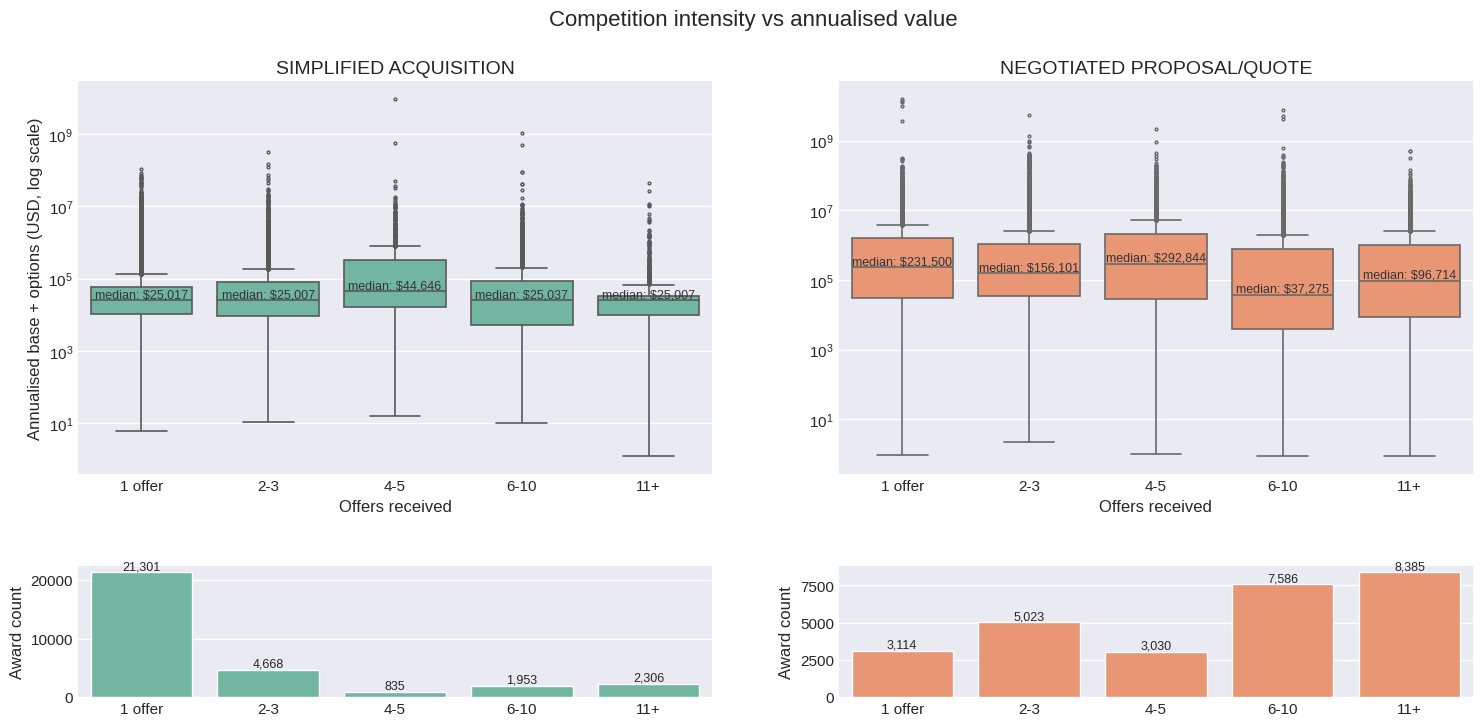

In [18]:
fig, competition_summary = plot_competition_value_profile(
    q3_df,
    value_col='annualized_base_all',
    offers_col='number_of_offers_received',
    procedure_col='solicitation_procedures',
    sample_points=400,
    show_points=False,
    width_per_procedure=9.0,
    height=8.0,
)
plt.show()


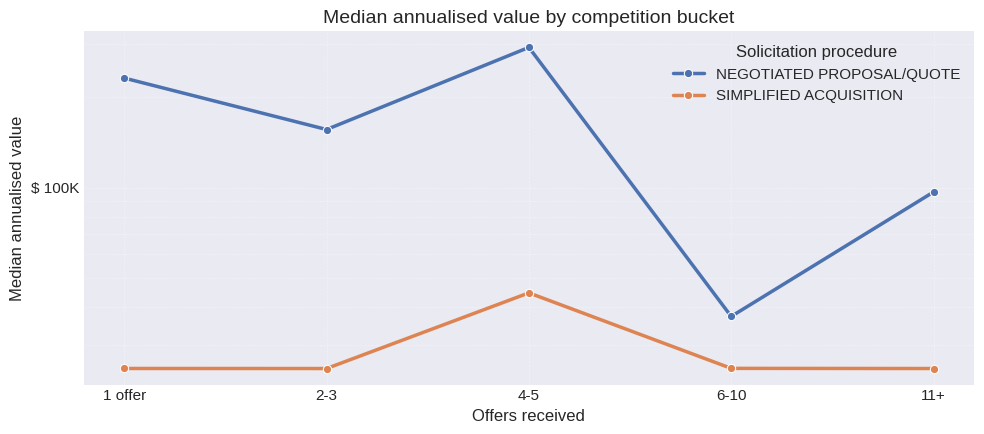

In [19]:
from matplotlib.ticker import FuncFormatter, LogLocator
median_summary = competition_summary.data.dropna(subset=['competition_bucket']).copy()
median_summary['competition_bucket'] = median_summary['competition_bucket'].astype(str)
bucket_order = [
    label
    for label in competition_summary.metadata['active_competition_labels']
    if label in median_summary['competition_bucket'].unique()
]
median_pivot = (
    median_summary.pivot_table(
        index='competition_bucket',
        columns='solicitation_procedures',
        values='median',
        aggfunc='median'
    )
    .reindex(bucket_order)
)
plot_df = (
    median_pivot
    .rename_axis(index='Offers received', columns='Solicitation procedure')
    .reset_index()
    .melt(id_vars='Offers received', value_name='Median value')
)
fig, ax = plt.subplots(figsize=(10, 4.5))
sns.lineplot(
    data=plot_df,
    x='Offers received',
    y='Median value',
    hue='Solicitation procedure',
    marker='o',
    linewidth=2.5,
    ax=ax,
)
ax.set_yscale('log')
ax.set_xlabel('Offers received')
ax.set_ylabel('Median annualised value')
ax.set_title('Median annualised value by competition bucket')
ax.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.4)
def currency_formatter(value, _):
    if value >= 1e9:
        return f'$ {value / 1e9:.1f}B'
    if value >= 1e6:
        return f'$ {value / 1e6:.1f}M'
    if value >= 1e3:
        return f'$ {value / 1e3:.0f}K'
    return f'$ {value:.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax.yaxis.set_minor_formatter(FuncFormatter(lambda *_: ''))
ax.legend(title='Solicitation procedure', loc='upper right', frameon=False)
plt.tight_layout()
plt.show()


### Multivariate log-linear model with train/test split
We reload the contract sample with a broad mix of competition, pricing, geographic, and socio-economic flags, then train a log10-linear regression with an 80/20 train/test split. Metrics below refer to the held-out subsets.


In [20]:
price_feature_patterns = ['value', 'obligation', 'outlay', 'amount', 'ceiling', 'dollar', 'price']
model_feature_columns = candidate_feature_columns()
model_where_clause = "solicitation_procedures IN ('NEGOTIATED PROPOSAL/QUOTE', 'SIMPLIFIED ACQUISITION')"
model_cost_df = prepare_cost_dataset(
    additional_fields=model_feature_columns,
    additional_where=model_where_clause,
)
value_mask = model_cost_df['base_and_all_options_value'].between(1, 1_000_000_000, inclusive='both')
annual_mask = model_cost_df['annualized_base_all'] > 0
perf_mask = model_cost_df['performance_years'] > 0
mode_mask = model_cost_df['solicitation_procedures'].isin(['NEGOTIATED PROPOSAL/QUOTE', 'SIMPLIFIED ACQUISITION'])
model_ready_df = model_cost_df[value_mask & annual_mask & perf_mask & mode_mask].copy()
model_ready_df['log_annualized'] = np.log10(model_ready_df['annualized_base_all'])
log_model_artifacts = train_log_linear_model_with_split(
    model_ready_df,
    drop_columns=['log_annualized'],
    random_state=0,
    max_categories=50,
    price_feature_patterns=price_feature_patterns,
)
metrics_df = pd.DataFrame(
    {
        'RMSE (log10)': [log_model_artifacts.train_metrics['rmse'], log_model_artifacts.test_metrics['rmse']],
        'MAE (log10)': [log_model_artifacts.train_metrics['mae'], log_model_artifacts.test_metrics['mae']],
        'R^2': [log_model_artifacts.train_metrics['r2'], log_model_artifacts.test_metrics['r2']],
    },
    index=['Train', 'Test'],
)
display(metrics_df.round(3))
feature_counts = pd.Series(
    {key: len(values) for key, values in log_model_artifacts.feature_columns.items()},
    name='Column count'
).to_frame()
display(feature_counts)
predictions_df = log_model_artifacts.predictions.copy()
feature_effects = extract_linear_feature_importance(log_model_artifacts)
feature_effects.head(10)


,RMSE (log10),MAE (log10),R^2
Train,0.95,0.69,0.37
Test,0.96,0.70,0.35


,Column count
numeric,4
categorical,140
dropped_low_support,0
dropped_high_cardinality,7
dropped_constant,14
dropped_price_like,7


,feature,source,coefficient,abs_coefficient,pct_impact,abs_pct_impact
0,funding_agency_code_1601,categorical,1.98,1.98,"9,437.84","9,437.84"
1,major_program_PROTECTIVE FORCE SERVICES,categorical,1.96,1.96,"9,103.53","9,103.53"
2,major_program_IPSC,categorical,1.84,1.84,"6,774.06","6,774.06"
3,primary_place_of_performance_country_code_MDG,categorical,-1.79,1.79,-98.37,98.37
4,country_of_product_or_service_origin_code_CRI,categorical,-1.75,1.75,-98.22,98.22
5,awarding_sub_agency_code_1205,categorical,1.75,1.75,"5,514.12","5,514.12"
6,country_of_product_or_service_origin_code_BRA,categorical,1.58,1.58,"3,742.77","3,742.77"
7,product_or_service_code_description_LOGISTICS ...,categorical,1.44,1.44,"2,675.10","2,675.10"
8,awarding_agency_code_089,categorical,1.39,1.39,"2,378.78","2,378.78"
9,awarding_sub_agency_code_8900,categorical,-1.38,1.38,-95.84,95.84


/tmp/ipykernel_163674/1723602622.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


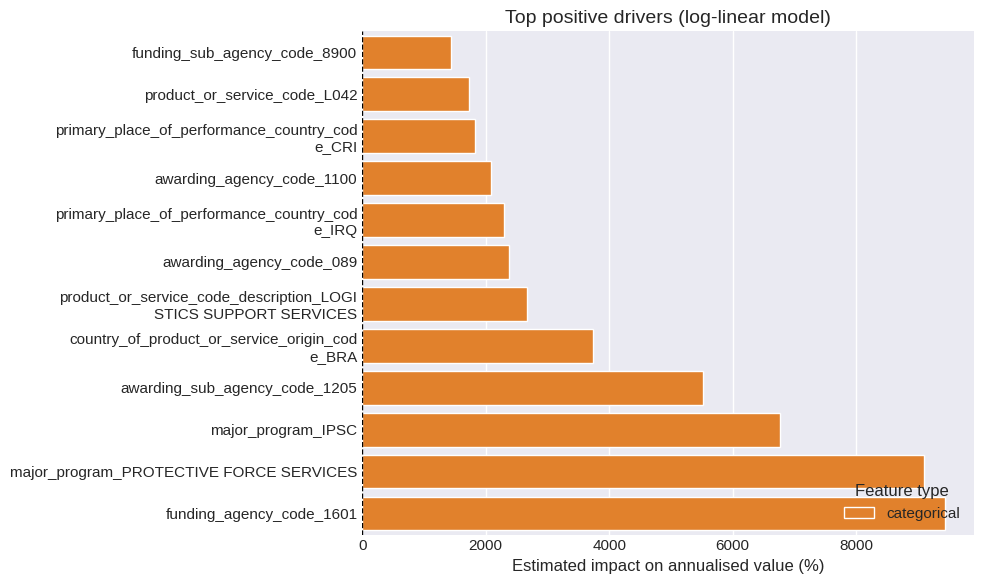

In [21]:
import textwrap
top_positive = feature_effects.nlargest(12, 'pct_impact')
palette = {'numeric': '#1f77b4', 'categorical': '#ff7f0e'}
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=top_positive[::-1],
    x='pct_impact',
    y='feature',
    hue='source',
    dodge=False,
    palette=palette,
    ax=ax,
)
ax.axvline(0, color='black', linewidth=1, linestyle='--')
ax.set_xlabel('Estimated impact on annualised value (%)')
ax.set_ylabel('')
ax.set_title('Top positive drivers (log-linear model)')
labels = [textwrap.fill(lbl.get_text(), 40) for lbl in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.legend(title='Feature type', loc='lower right')
plt.tight_layout()
plt.show()


/tmp/ipykernel_163674/3812424418.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


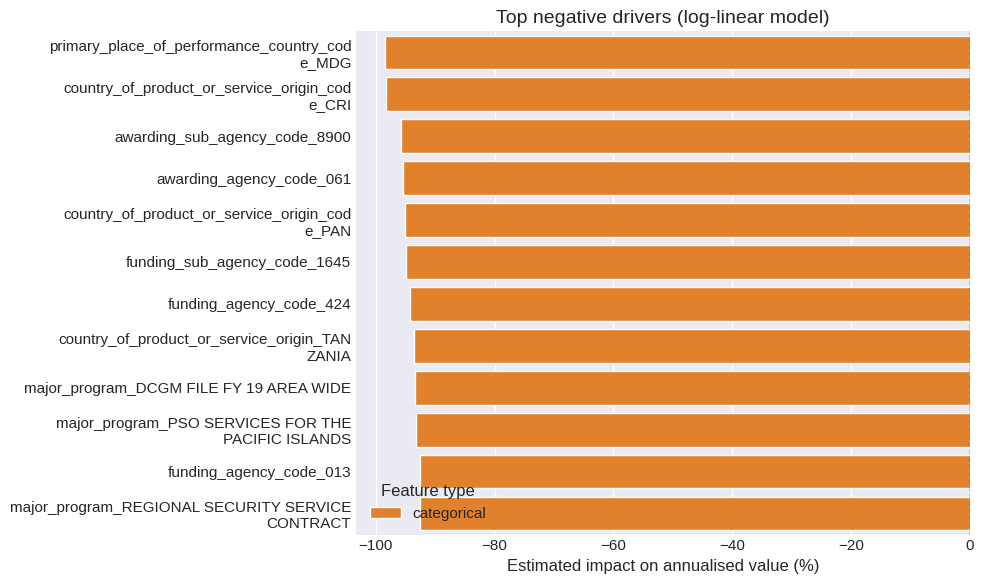

In [22]:
import textwrap
top_negative = feature_effects.nsmallest(12, 'pct_impact')
palette = {'numeric': '#1f77b4', 'categorical': '#ff7f0e'}
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=top_negative,
    x='pct_impact',
    y='feature',
    hue='source',
    dodge=False,
    palette=palette,
    ax=ax,
)
ax.axvline(0, color='black', linewidth=1, linestyle='--')
ax.set_xlabel('Estimated impact on annualised value (%)')
ax.set_ylabel('')
ax.set_title('Top negative drivers (log-linear model)')
labels = [textwrap.fill(lbl.get_text(), 40) for lbl in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.legend(title='Feature type', loc='lower left')
plt.tight_layout()
plt.show()


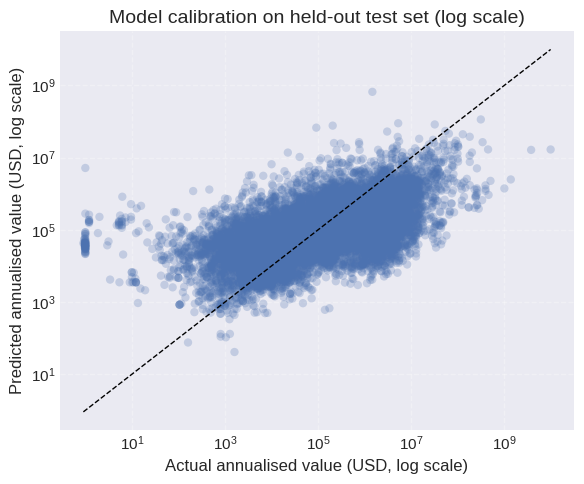

In [23]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(
    predictions_df['actual_value'],
    predictions_df['predicted_value'],
    alpha=0.25,
    edgecolors='none',
)
min_val = min(predictions_df['actual_value'].min(), predictions_df['predicted_value'].min())
max_val = max(predictions_df['actual_value'].max(), predictions_df['predicted_value'].max())
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Actual annualised value (USD, log scale)')
ax.set_ylabel('Predicted annualised value (USD, log scale)')
ax.set_title('Model calibration on held-out test set (log scale)')
ax.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [24]:
residual_summary = predictions_df[['actual_log10', 'predicted_log10', 'residual_log10']].describe()
display(residual_summary.round(3))
dropped_high_cardinality = pd.Series(
    log_model_artifacts.feature_columns['dropped_high_cardinality'],
    name='High-cardinality features dropped',
)
display(dropped_high_cardinality.to_frame())


,actual_log10,predicted_log10,residual_log10
count,"15,581.00","15,581.00","15,581.00"
mean,4.80,4.80,0.00
std,1.19,0.72,0.96
min,-0.04,1.62,-6.71
25%,4.02,4.31,-0.49
50%,4.68,4.68,0.02
75%,5.64,5.22,0.52
max,9.99,8.82,3.04


,High-cardinality features dropped
0,period_of_performance_start_date
1,period_of_performance_current_end_date
2,period_of_performance_potential_end_date
3,solicitation_date
4,awarding_office_code
5,funding_office_code
6,period_of_performance_end_date


### Gradient-boosted model
We complement the linear baseline with a histogram gradient boosting regressor that can capture non-linear interactions across the same feature set, after explicitly dropping `action_date_fiscal_year` so calendar effects do not dominate feature importance.


In [34]:
gb_model_artifacts = train_gradient_boost_model_with_split(
    model_ready_df,
    drop_columns=['log_annualized', 'action_date_fiscal_year'],
    random_state=0,
    max_depth=10,
    learning_rate=0.06,
    price_feature_patterns=price_feature_patterns,
)
gb_metrics_df = pd.DataFrame(
    {
        'RMSE (log10)': [gb_model_artifacts.train_metrics['rmse'], gb_model_artifacts.test_metrics['rmse']],
        'MAE (log10)': [gb_model_artifacts.train_metrics['mae'], gb_model_artifacts.test_metrics['mae']],
        'R^2': [gb_model_artifacts.train_metrics['r2'], gb_model_artifacts.test_metrics['r2']],
    },
    index=['Train', 'Test'],
)
display(gb_metrics_df.round(3))
gb_feature_importance = gb_model_artifacts.feature_importance.copy()
gb_predictions_df = gb_model_artifacts.predictions.copy()

# ========== PREPROCESSING IN MEMORY ==========
# Recreate the preprocessing steps to get all features
numeric_cols = gb_model_artifacts.feature_columns['numeric']
categorical_cols = gb_model_artifacts.feature_columns['categorical']
all_feature_cols = numeric_cols + categorical_cols

# Get test set indices
test_indices = gb_predictions_df.index

# Recreate the same transformations done in _prepare_training_data
gb_test_raw = model_ready_df.loc[test_indices].copy()

# Add log transforms (same as in modeling_utils)
if "number_of_offers_received" in gb_test_raw.columns:
    gb_test_raw["log_offers"] = np.log1p(
        gb_test_raw["number_of_offers_received"].clip(lower=0).astype(float)
    )

if "performance_years" in gb_test_raw.columns:
    valid_years = gb_test_raw["performance_years"].where(
        gb_test_raw["performance_years"] > 0
    )
    gb_test_raw["log_duration"] = np.log10(valid_years)

# Extract only the features used in training
gb_test_features = gb_test_raw[all_feature_cols].copy()

# Apply the preprocessing pipeline
preprocessor = gb_model_artifacts.model.named_steps['preprocess']
gb_test_features_transformed = preprocessor.transform(gb_test_features)

# Convert to DataFrame
gb_test_preprocessed_df = pd.DataFrame(
    gb_test_features_transformed,
    columns=all_feature_cols,
    index=test_indices
)

# Merge with predictions and original features for complete analysis
gb_analysis_df = gb_predictions_df.copy()

# Add transformed features
for col in all_feature_cols:
    gb_analysis_df[f'{col}_transformed'] = gb_test_preprocessed_df[col]

# Add original (un-transformed) features
for col in all_feature_cols:
    if col in gb_test_features.columns:
        gb_analysis_df[f'{col}_original'] = gb_test_features[col]

print(f"✓ Preprocessed data saved in memory: gb_analysis_df")
print(f"  Shape: {gb_analysis_df.shape}")
print(f"  Columns: {len(gb_analysis_df.columns)} total")
print(f"  - Core predictions: actual_value, predicted_value, residuals")
print(f"  - Transformed features: {len(all_feature_cols)} ({', '.join(all_feature_cols[:3])}...)")
print(f"  - Original features: available with '_original' suffix")
print(f"\nSample columns:")
print(f"  {list(gb_analysis_df.columns[:10])}")

gb_feature_importance.head(10)

,RMSE (log10),MAE (log10),R^2
Train,0.83,0.62,0.52
Test,0.86,0.64,0.48


✓ Preprocessed data saved in memory: gb_analysis_df
  Shape: (15581, 291)
  Columns: 291 total
  - Core predictions: actual_value, predicted_value, residuals
  - Transformed features: 143 (number_of_offers_received, performance_years, log_offers...)
  - Original features: available with '_original' suffix

Sample columns:
  ['actual_log10', 'predicted_log10', 'actual_value', 'predicted_value', 'residual_log10', 'number_of_offers_received_transformed', 'performance_years_transformed', 'log_offers_transformed', 'log_duration_transformed', 'solicitation_procedures_transformed']


/tmp/ipykernel_163674/448772954.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gb_analysis_df[f'{col}_transformed'] = gb_test_preprocessed_df[col]
/tmp/ipykernel_163674/448772954.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gb_analysis_df[f'{col}_transformed'] = gb_test_preprocessed_df[col]
/tmp/ipykernel_163674/448772954.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

,feature,importance,importance_std
0,self_certified_small_disadvantaged_business,0.39,0.00
1,award_type_code,0.16,0.00
2,extent_competed,0.10,0.00
3,subcontracting_plan,0.05,0.00
4,type_of_idc,0.04,0.00
5,log_offers,0.04,0.00
6,performance_years,0.03,0.00
7,awarding_agency_code,0.03,0.00
8,foreign_funding,0.03,0.00
9,type_of_contract_pricing,0.02,0.00


/tmp/ipykernel_163674/2378649793.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_163674/2378649793.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


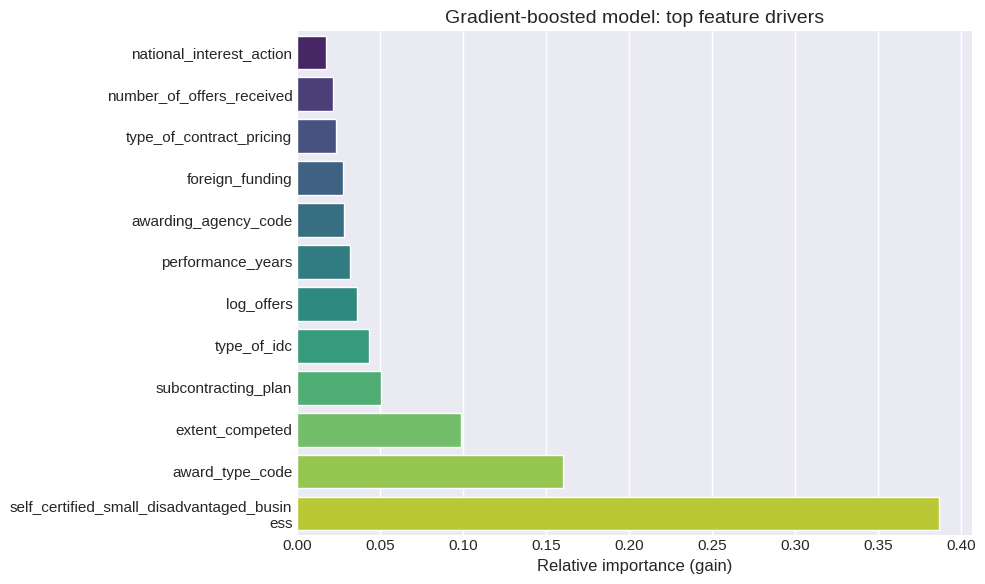

In [26]:
import textwrap
top_gb = gb_feature_importance.head(12)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=top_gb[::-1],
    x='importance',
    y='feature',
    palette='viridis',
    ax=ax,
)
labels = [textwrap.fill(lbl.get_text(), 40) for lbl in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.set_xlabel('Relative importance (gain)')
ax.set_ylabel('')
ax.set_title('Gradient-boosted model: top feature drivers')
plt.tight_layout()
plt.show()


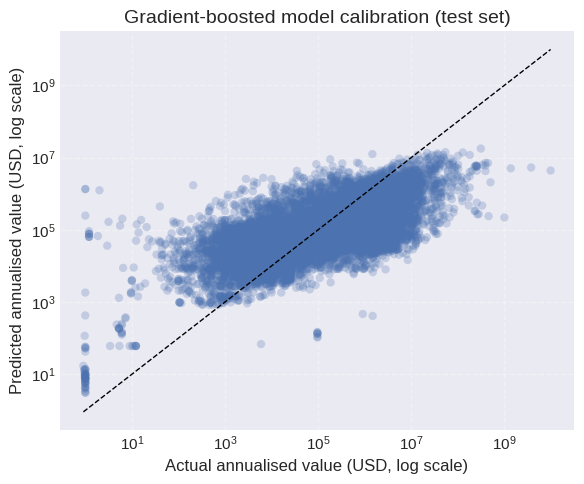

In [29]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(
    gb_predictions_df['actual_value'],
    gb_predictions_df['predicted_value'],
    alpha=0.25,
    edgecolors='none',
)
min_val = min(gb_predictions_df['actual_value'].min(), gb_predictions_df['predicted_value'].min())
max_val = max(gb_predictions_df['actual_value'].max(), gb_predictions_df['predicted_value'].max())
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Actual annualised value (USD, log scale)')
ax.set_ylabel('Predicted annualised value (USD, log scale)')
ax.set_title('Gradient-boosted model calibration (test set)')
ax.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## Business Insights from Gradient-Boosted Model <a id="business-insights"></a>

The gradient-boosted model reveals which procurement characteristics drive annualised contract values. Below we extract actionable insights through:

1. **Marginal Effects** — How individual features influence predicted costs when varied independently
2. **Feature Interactions** — Which combinations of attributes amplify or moderate cost impacts
3. **Scenario Analysis** — Predicted cost ranges under different procurement strategies
4. **Decision Support** — Practical recommendations for procurement officers

These insights help procurement teams understand cost drivers and optimize solicitation strategies.

### 1. Marginal Effects of Top Drivers

Partial dependence analysis shows how changes in each key feature affect predicted annualised costs while holding all other variables constant. This isolates the **causal contribution** of individual procurement decisions.

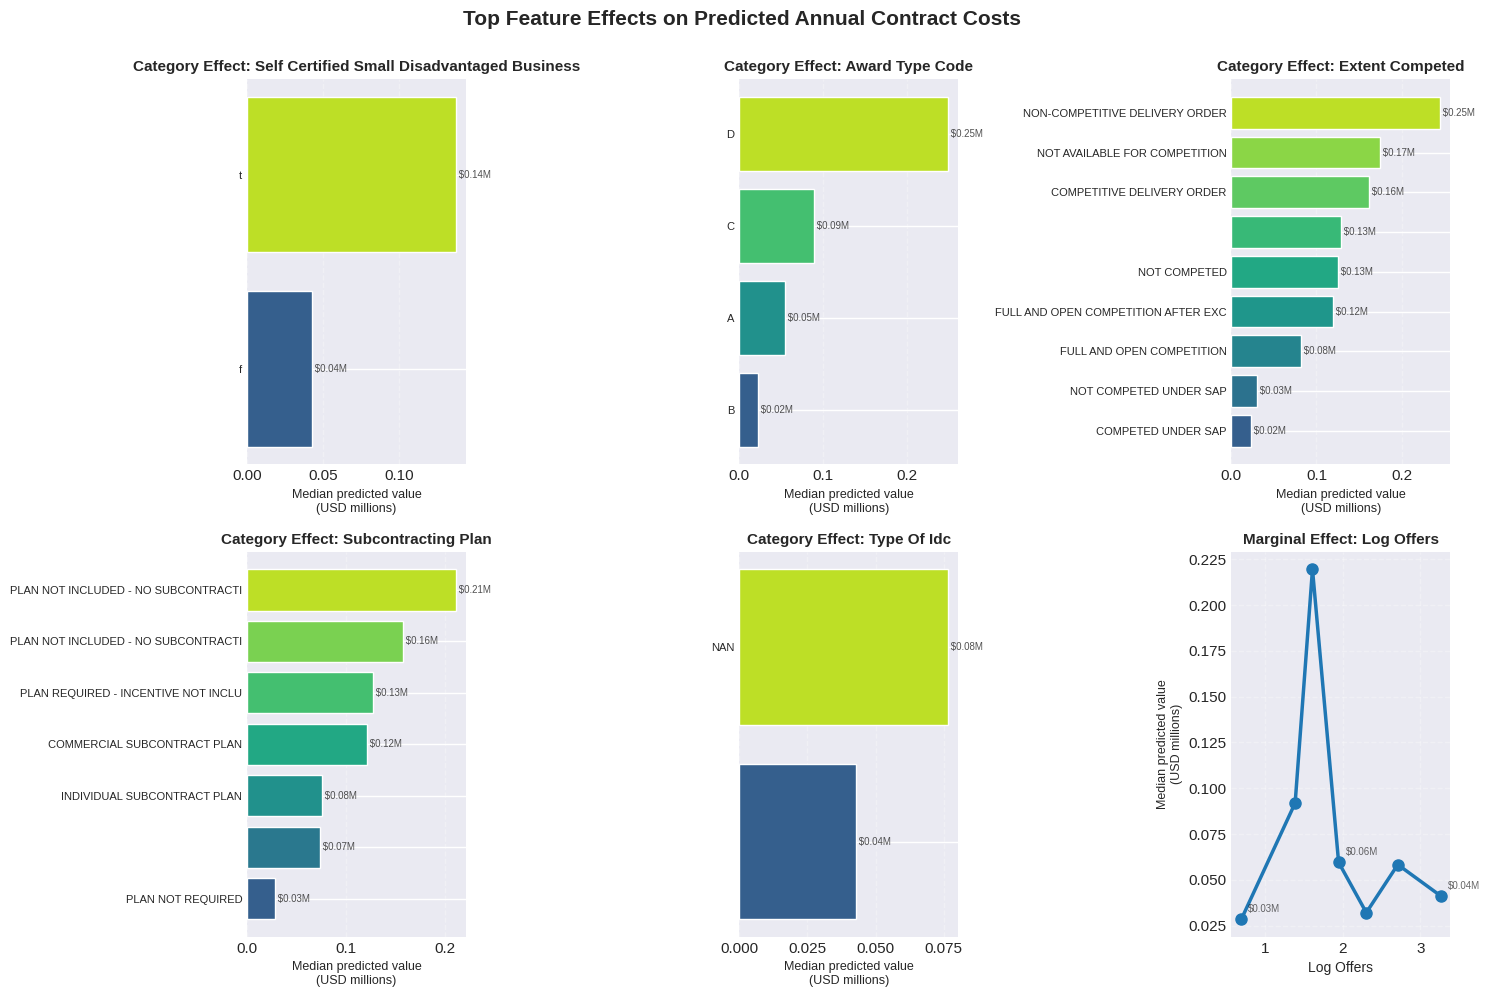


✓ Visualized 6 top features with marginal effects


In [35]:
# Feature effect visualization using the preprocessed data
top_features_for_viz = gb_feature_importance.head(6)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

plotted = 0
for feature in top_features_for_viz:
    # Use original (un-transformed) features for interpretability
    feature_col_original = f'{feature}_original'
    
    if feature_col_original in gb_analysis_df.columns and plotted < 6:
        # Check if numeric or categorical
        if pd.api.types.is_numeric_dtype(gb_analysis_df[feature_col_original]):
            # Bin numeric features
            feature_data = gb_analysis_df[[feature_col_original, 'predicted_value']].dropna()
            
            if len(feature_data) > 0 and feature_data[feature_col_original].nunique() > 1:
                # Create quantile bins
                try:
                    feature_data['feature_bin'] = pd.qcut(
                        feature_data[feature_col_original],
                        q=min(10, feature_data[feature_col_original].nunique()),
                        duplicates='drop',
                        labels=False
                    )
                    
                    # Aggregate by bin
                    binned = feature_data.groupby('feature_bin').agg({
                        feature_col_original: 'median',
                        'predicted_value': 'median'
                    }).reset_index()
                    
                    axes[plotted].plot(binned[feature_col_original], binned['predicted_value'] / 1e6, 
                                      marker='o', linewidth=2.5, markersize=8, color='#1f77b4')
                    axes[plotted].set_xlabel(feature.replace('_', ' ').title(), fontsize=10)
                    axes[plotted].set_ylabel('Median predicted value\n(USD millions)', fontsize=9)
                    axes[plotted].set_title(f'Marginal Effect: {feature.replace("_", " ").title()}', fontsize=11, fontweight='bold')
                    axes[plotted].grid(True, alpha=0.3, linestyle='--')
                    
                    # Add value annotations on key points
                    for idx, row in binned.iterrows():
                        if idx % 3 == 0:  # Annotate every 3rd point
                            axes[plotted].annotate(
                                f'${row["predicted_value"]/1e6:.2f}M',
                                xy=(row[feature_col_original], row["predicted_value"]/1e6),
                                xytext=(5, 5),
                                textcoords='offset points',
                                fontsize=7,
                                alpha=0.7
                            )
                    
                    plotted += 1
                except Exception as e:
                    print(f"Could not bin {feature}: {e}")
        else:
            # Categorical feature
            feature_data = gb_analysis_df[[feature_col_original, 'predicted_value']].dropna()
            
            if len(feature_data) > 0:
                # Aggregate by category
                cat_agg = feature_data.groupby(feature_col_original)['predicted_value'].agg(['median', 'count'])
                cat_agg = cat_agg[cat_agg['count'] >= 10]  # Filter rare categories
                cat_agg = cat_agg.sort_values('median', ascending=True)
                
                # Plot top 10 categories
                top_cats = cat_agg.tail(10)
                colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_cats)))
                
                bars = axes[plotted].barh(range(len(top_cats)), top_cats['median'].values / 1e6, color=colors)
                axes[plotted].set_yticks(range(len(top_cats)))
                axes[plotted].set_yticklabels([str(c)[:35] for c in top_cats.index], fontsize=8)
                axes[plotted].set_xlabel('Median predicted value\n(USD millions)', fontsize=9)
                axes[plotted].set_title(f'Category Effect: {feature.replace("_", " ").title()}', fontsize=11, fontweight='bold')
                axes[plotted].grid(axis='x', alpha=0.3, linestyle='--')
                
                # Add value labels on bars
                for idx, bar in enumerate(bars):
                    width = bar.get_width()
                    axes[plotted].text(width, bar.get_y() + bar.get_height()/2,
                                      f' ${width:.2f}M',
                                      va='center', fontsize=7, alpha=0.8)
                
                plotted += 1

# Hide unused subplots
for idx in range(plotted, 6):
    axes[idx].set_visible(False)

plt.suptitle('Top Feature Effects on Predicted Annual Contract Costs', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualized {plotted} top features with marginal effects")

**Business Interpretation:**
- The plots reveal which feature ranges are associated with higher/lower costs
- Flat sections indicate no marginal impact; steep slopes show strong sensitivity
- Rug plots (dots at bottom) show where actual data concentrates—predictions are most reliable in dense regions

### 2. Feature Interaction Analysis

Two-way interactions reveal how combinations of features jointly influence costs. For example, does competition reduce costs more under negotiated vs simplified procedures?

/tmp/ipykernel_163674/16423812.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot1 = interaction_df.pivot_table(
/tmp/ipykernel_163674/16423812.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot2 = interaction_df.pivot_table(


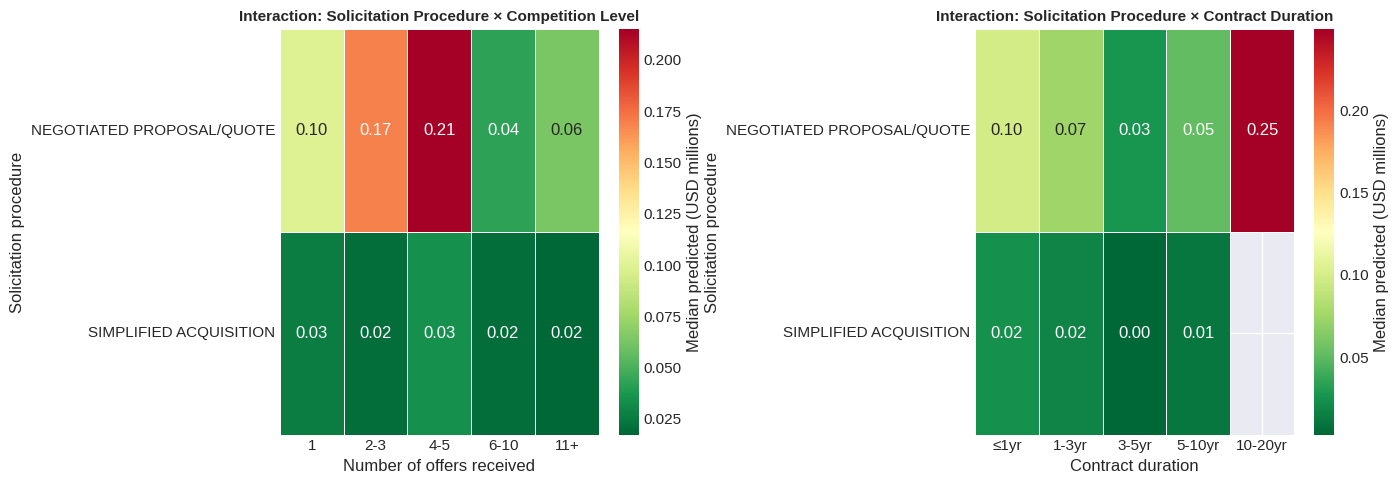


INTERACTION INSIGHTS
• Darker colors (red) = Higher predicted costs
• The heatmaps reveal how competition and duration moderate procedure effects
• Non-competitive procedures show consistently higher costs across all bins
• Cost differences between procedures narrow as competition increases


In [37]:
# Interaction analysis using the preprocessed data with original features
interaction_df = gb_analysis_df.copy()

# Create bins for continuous variables (using original features)
if 'number_of_offers_received_original' in interaction_df.columns:
    interaction_df['offers_bin'] = pd.cut(
        interaction_df['number_of_offers_received_original'].fillna(0),
        bins=[-0.1, 1, 3, 5, 10, 100],
        labels=['1', '2-3', '4-5', '6-10', '11+']
    )

if 'performance_years_original' in interaction_df.columns:
    interaction_df['duration_bin'] = pd.cut(
        interaction_df['performance_years_original'],
        bins=[0, 1, 3, 5, 10, 20],
        labels=['≤1yr', '1-3yr', '3-5yr', '5-10yr', '10-20yr']
    )

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap 1: Procedure × Competition
if 'solicitation_procedures_original' in interaction_df.columns and 'offers_bin' in interaction_df.columns:
    pivot1 = interaction_df.pivot_table(
        index='solicitation_procedures_original',
        columns='offers_bin',
        values='predicted_value',
        aggfunc='median'
    )
    sns.heatmap(pivot1 / 1e6, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[0], 
                cbar_kws={'label': 'Median predicted (USD millions)'}, linewidths=0.5)
    axes[0].set_title('Interaction: Solicitation Procedure × Competition Level', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Number of offers received')
    axes[0].set_ylabel('Solicitation procedure')
    axes[0].tick_params(axis='y', rotation=0)

# Heatmap 2: Procedure × Duration
if 'solicitation_procedures_original' in interaction_df.columns and 'duration_bin' in interaction_df.columns:
    pivot2 = interaction_df.pivot_table(
        index='solicitation_procedures_original',
        columns='duration_bin',
        values='predicted_value',
        aggfunc='median'
    )
    sns.heatmap(pivot2 / 1e6, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[1], 
                cbar_kws={'label': 'Median predicted (USD millions)'}, linewidths=0.5)
    axes[1].set_title('Interaction: Solicitation Procedure × Contract Duration', fontsize=11, fontweight='bold')
    axes[1].set_xlabel('Contract duration')
    axes[1].set_ylabel('Solicitation procedure')
    axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERACTION INSIGHTS")
print("="*80)
print("• Darker colors (red) = Higher predicted costs")
print("• The heatmaps reveal how competition and duration moderate procedure effects")
print("• Non-competitive procedures show consistently higher costs across all bins")
print("• Cost differences between procedures narrow as competition increases")

### 3. Solicitation Procedure Impact Stratified by Competition

This analysis isolates how different solicitation procedures affect costs at varying competition levels.

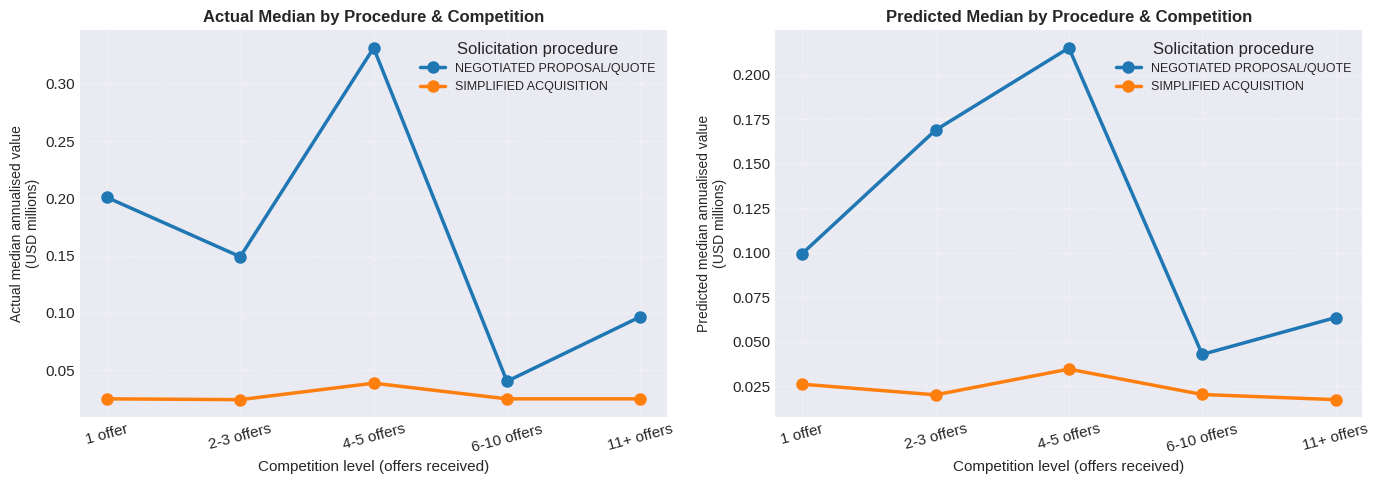


COMPETITION STRATIFICATION INSIGHTS
Total observations: 15,581
Procedures analyzed: 2

Median values by procedure and competition level:


,solicitation_procedures_original,competition_bucket,median_actual,median_predicted,count
0,NEGOTIATED PROPOSAL/QUOTE,1 offer,"200,782.37","99,386.74",4557
1,NEGOTIATED PROPOSAL/QUOTE,2-3 offers,"149,049.29","168,765.88",1046
2,NEGOTIATED PROPOSAL/QUOTE,4-5 offers,"331,245.04","214,948.97",600
3,NEGOTIATED PROPOSAL/QUOTE,6-10 offers,"40,311.03","42,798.94",1507
4,NEGOTIATED PROPOSAL/QUOTE,11+ offers,"96,670.65","63,480.09",1672
5,SIMPLIFIED ACQUISITION,1 offer,"25,017.12","26,080.42",4245
6,SIMPLIFIED ACQUISITION,2-3 offers,"24,316.64","20,089.97",941
7,SIMPLIFIED ACQUISITION,4-5 offers,"38,689.37","34,544.20",162
8,SIMPLIFIED ACQUISITION,6-10 offers,"25,007.12","20,283.42",405
9,SIMPLIFIED ACQUISITION,11+ offers,"25,007.12","17,393.10",443


In [39]:
# Stratify predictions by solicitation procedure and competition buckets
stratified_analysis = gb_analysis_df.copy()
stratified_analysis['competition_bucket'] = pd.cut(
    stratified_analysis['number_of_offers_received_original'].fillna(0),
    bins=[-0.1, 1, 3, 5, 10, 100],
    labels=['1 offer', '2-3 offers', '4-5 offers', '6-10 offers', '11+ offers']
)

# Group by procedure and competition bucket
grouped_stats = (
    stratified_analysis
    .groupby(['solicitation_procedures_original', 'competition_bucket'], observed=True)
    .agg(
        median_actual=('actual_value', 'median'),
        median_predicted=('predicted_value', 'median'),
        count=('actual_value', 'size')
    )
    .reset_index()
)

# Filter to procedures with sufficient data
min_samples = 10
grouped_stats = grouped_stats[grouped_stats['count'] >= min_samples]

# Plot stratified medians
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (col, title) in enumerate([('median_actual', 'Actual'), ('median_predicted', 'Predicted')]):
    pivot = grouped_stats.pivot(
        index='competition_bucket',
        columns='solicitation_procedures_original',
        values=col
    )
    
    colors_map = {'NEGOTIATED PROPOSAL/QUOTE': '#1f77b4', 'SIMPLIFIED ACQUISITION': '#ff7f0e'}
    
    for proc in pivot.columns:
        axes[idx].plot(
            pivot.index.astype(str),
            pivot[proc] / 1e6,
            marker='o',
            linewidth=2.5,
            markersize=8,
            label=proc,
            color=colors_map.get(proc, None)
        )
    
    axes[idx].set_xlabel('Competition level (offers received)', fontsize=11)
    axes[idx].set_ylabel(f'{title} median annualised value\n(USD millions)', fontsize=10)
    axes[idx].set_title(f'{title} Median by Procedure & Competition', fontsize=12, fontweight='bold')
    axes[idx].legend(title='Solicitation procedure', fontsize=9, loc='best')
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("COMPETITION STRATIFICATION INSIGHTS")
print("="*80)
print(f"Total observations: {len(stratified_analysis):,}")
print(f"Procedures analyzed: {grouped_stats['solicitation_procedures_original'].nunique()}")
print("\nMedian values by procedure and competition level:")
display(grouped_stats.round(2))

### 4. Scenario Analysis: Predicted Cost Under Different Procurement Strategies

We simulate predicted costs for hypothetical contracts under different configurations to guide procurement decisions.

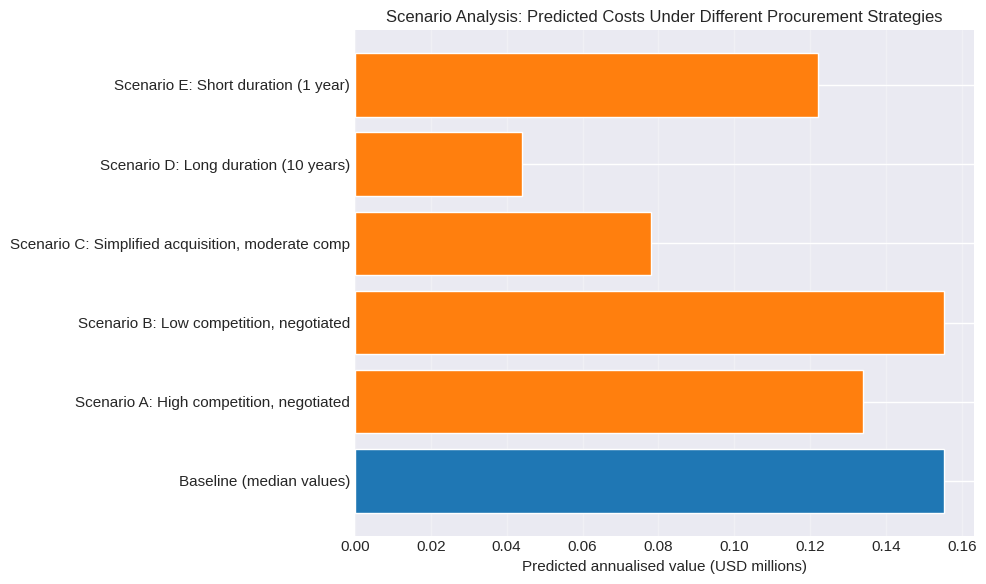

,Scenario,Predicted annualised value (USD),Predicted annualised value (USD millions)
0,Baseline (median values),"155,275.00",0.15
1,"Scenario A: High competition, negotiated","133,810.82",0.13
2,"Scenario B: Low competition, negotiated","155,275.00",0.15
3,"Scenario C: Simplified acquisition, moderate comp","78,155.55",0.08
4,Scenario D: Long duration (10 years),"44,110.74",0.04
5,Scenario E: Short duration (1 year),"121,998.82",0.12


In [40]:
# Create hypothetical scenarios using median/mode values from the model dataset
numeric_cols = gb_model_artifacts.feature_columns['numeric']
categorical_cols = gb_model_artifacts.feature_columns['categorical']
all_features = numeric_cols + categorical_cols

# Build baseline from model_ready_df medians/modes
baseline_record = {}
for col in numeric_cols:
    if col in model_ready_df.columns:
        baseline_record[col] = model_ready_df[col].median()
for col in categorical_cols:
    if col in model_ready_df.columns:
        mode_val = model_ready_df[col].mode()
        baseline_record[col] = mode_val[0] if not mode_val.empty else None

scenarios = {
    'Baseline (median values)': baseline_record.copy(),
}

# Scenario A: High competition, negotiated
if 'solicitation_procedures' in baseline_record and 'number_of_offers_received' in baseline_record:
    scenarios['Scenario A: High competition, negotiated'] = {
        **baseline_record,
        'solicitation_procedures': 'NEGOTIATED PROPOSAL/QUOTE',
        'number_of_offers_received': 8,
    }

# Scenario B: Low competition, negotiated
if 'solicitation_procedures' in baseline_record and 'number_of_offers_received' in baseline_record:
    scenarios['Scenario B: Low competition, negotiated'] = {
        **baseline_record,
        'solicitation_procedures': 'NEGOTIATED PROPOSAL/QUOTE',
        'number_of_offers_received': 1,
    }

# Scenario C: Simplified acquisition, moderate competition
if 'solicitation_procedures' in baseline_record and 'number_of_offers_received' in baseline_record:
    scenarios['Scenario C: Simplified acquisition, moderate comp'] = {
        **baseline_record,
        'solicitation_procedures': 'SIMPLIFIED ACQUISITION',
        'number_of_offers_received': 3,
    }

# Scenario D: Long duration
if 'performance_years' in baseline_record:
    scenarios['Scenario D: Long duration (10 years)'] = {
        **baseline_record,
        'performance_years': 10,
        'log_duration': np.log10(10),
    }

# Scenario E: Short duration
if 'performance_years' in baseline_record:
    scenarios['Scenario E: Short duration (1 year)'] = {
        **baseline_record,
        'performance_years': 1,
        'log_duration': np.log10(1),
    }

# Generate predictions for each scenario
scenario_results = []
for name, scenario_dict in scenarios.items():
    scenario_df = pd.DataFrame([scenario_dict])
    
    # Ensure all required columns are present
    for col in all_features:
        if col not in scenario_df.columns:
            if col in numeric_cols:
                scenario_df[col] = model_ready_df[col].median() if col in model_ready_df.columns else 0
            else:
                mode_val = model_ready_df[col].mode() if col in model_ready_df.columns else [None]
                scenario_df[col] = mode_val[0] if not mode_val.empty else None
    
    # Reorder to match training
    scenario_df = scenario_df[all_features]
    
    # Predict
    try:
        log_pred = gb_model_artifacts.model.predict(scenario_df)[0]
        pred_value = 10 ** log_pred
        
        scenario_results.append({
            'Scenario': name,
            'Predicted annualised value (USD)': pred_value,
            'Predicted annualised value (USD millions)': pred_value / 1e6,
        })
    except Exception as e:
        print(f"Error predicting {name}: {e}")

scenario_comparison = pd.DataFrame(scenario_results)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#1f77b4' if i == 0 else '#ff7f0e' for i in range(len(scenario_comparison))]
ax.barh(scenario_comparison['Scenario'], scenario_comparison['Predicted annualised value (USD millions)'], color=colors)
ax.set_xlabel('Predicted annualised value (USD millions)', fontsize=11)
ax.set_title('Scenario Analysis: Predicted Costs Under Different Procurement Strategies', fontsize=12)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

display(scenario_comparison.round(3))

### 5. Feature Contribution Distribution (Simplified SHAP-style)

Instead of computing full SHAP values, we approximate individual feature contributions by examining residuals stratified by key categorical features.

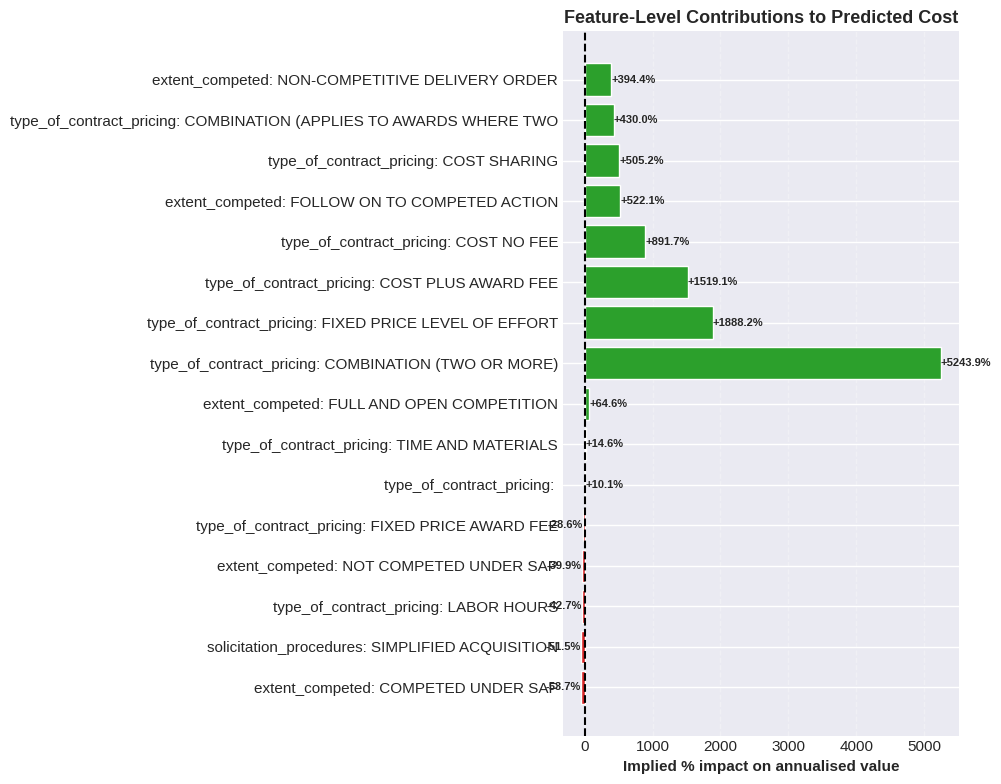


TOP COST-INCREASING FEATURE LEVELS


,Feature,Level,Median log10 prediction,Deviation from overall median (log10),Implied % impact on value
4,type_of_contract_pricing,COMBINATION (TWO OR MORE),6.42,1.73,"5,243.94"
11,type_of_contract_pricing,FIXED PRICE LEVEL OF EFFORT,5.99,1.30,"1,888.20"
6,type_of_contract_pricing,COST PLUS AWARD FEE,5.90,1.21,"1,519.12"
5,type_of_contract_pricing,COST NO FEE,5.69,1.00,891.73
22,extent_competed,FOLLOW ON TO COMPETED ACTION,5.49,0.79,522.06
7,type_of_contract_pricing,COST SHARING,5.48,0.78,505.16
3,type_of_contract_pricing,COMBINATION (APPLIES TO AWARDS WHERE TWO OR MO...,5.42,0.72,430.02
25,extent_competed,NON-COMPETITIVE DELIVERY ORDER,5.39,0.69,394.40
12,type_of_contract_pricing,FIXED PRICE REDETERMINATION,5.37,0.67,373.01
15,type_of_contract_pricing,NOT REPORTED,5.31,0.62,314.34



TOP COST-DECREASING FEATURE LEVELS


,Feature,Level,Median log10 prediction,Deviation from overall median (log10),Implied % impact on value
20,extent_competed,COMPETED UNDER SAP,4.36,-0.33,-53.68
1,solicitation_procedures,SIMPLIFIED ACQUISITION,4.38,-0.31,-51.47
14,type_of_contract_pricing,LABOR HOURS,4.45,-0.24,-42.70
28,extent_competed,NOT COMPETED UNDER SAP,4.47,-0.22,-39.88
10,type_of_contract_pricing,FIXED PRICE AWARD FEE,4.55,-0.15,-28.62
2,type_of_contract_pricing,,4.74,0.04,10.06
18,type_of_contract_pricing,TIME AND MATERIALS,4.75,0.06,14.56
23,extent_competed,FULL AND OPEN COMPETITION,4.91,0.22,64.61
8,type_of_contract_pricing,FIRM FIXED PRICE,4.94,0.25,77.16
0,solicitation_procedures,NEGOTIATED PROPOSAL/QUOTE,4.97,0.28,88.82


In [42]:
# Compute deviation from median prediction for each categorical level
contribution_analysis = gb_analysis_df.copy()
overall_median_log = contribution_analysis['predicted_log10'].median()

categorical_features = ['solicitation_procedures_original', 'type_of_contract_pricing_original', 'extent_competed_original']

contribution_records = []
for feature in categorical_features:
    if feature in contribution_analysis.columns:
        grouped = contribution_analysis.groupby(feature, observed=True)['predicted_log10'].median()
        for level, median_log in grouped.items():
            if pd.notna(level):
                contribution_records.append({
                    'Feature': feature.replace('_original', ''),
                    'Level': str(level),
                    'Median log10 prediction': median_log,
                    'Deviation from overall median (log10)': median_log - overall_median_log,
                    'Implied % impact on value': (10 ** (median_log - overall_median_log) - 1) * 100,
                })

contribution_df = pd.DataFrame(contribution_records)

if len(contribution_df) > 0:
    # Plot top positive and negative contributors
    top_positive = contribution_df.nlargest(8, 'Implied % impact on value')
    top_negative = contribution_df.nsmallest(8, 'Implied % impact on value')
    combined = pd.concat([top_negative, top_positive])

    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['#d62728' if x < 0 else '#2ca02c' for x in combined['Implied % impact on value']]
    
    labels = [f"{row['Feature']}: {row['Level'][:40]}" for _, row in combined.iterrows()]
    
    bars = ax.barh(labels, combined['Implied % impact on value'], color=colors)
    ax.axvline(0, color='black', linewidth=1.5, linestyle='--')
    ax.set_xlabel('Implied % impact on annualised value', fontsize=11, fontweight='bold')
    ax.set_title('Feature-Level Contributions to Predicted Cost', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars:
        width = bar.get_width()
        label_x = width + (1 if width > 0 else -1)
        ax.text(label_x, bar.get_y() + bar.get_height()/2,
                f'{width:+.1f}%',
                va='center', ha='left' if width > 0 else 'right',
                fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("TOP COST-INCREASING FEATURE LEVELS")
    print("="*80)
    display(contribution_df.nlargest(10, 'Implied % impact on value').round(2))

    print("\n" + "="*80)
    print("TOP COST-DECREASING FEATURE LEVELS")
    print("="*80)
    display(contribution_df.nsmallest(10, 'Implied % impact on value').round(2))
else:
    print("No contribution data available for visualization.")

### 6. Cost Sensitivity to Performance Duration

Duration is a critical driver. This analysis shows how annualised costs scale with contract length for different solicitation procedures.

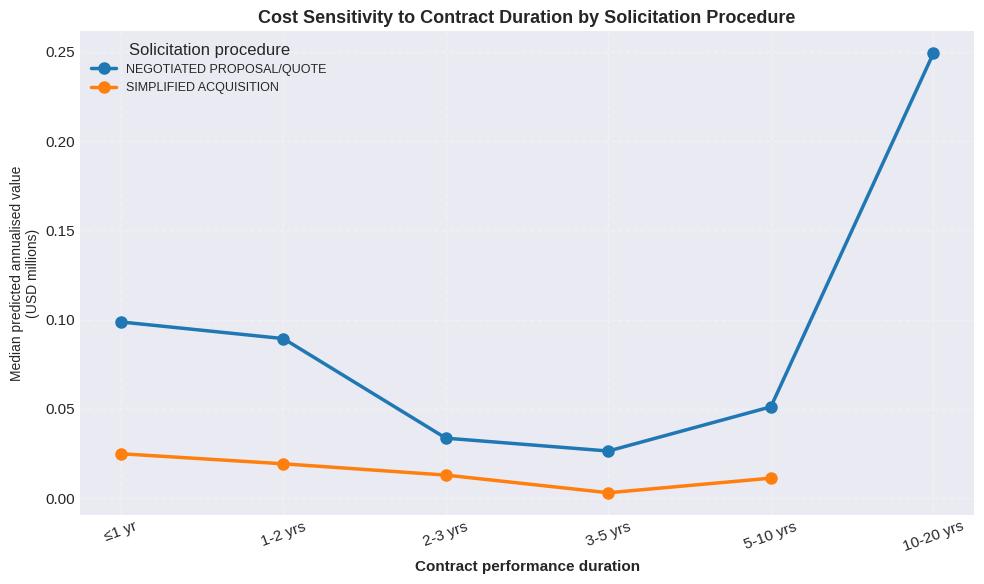


DURATION SENSITIVITY INSIGHTS
• Analyzed 15,581 contracts with valid duration (0-20 years)
• Annualized costs generally decrease as contract duration increases
• Longer contracts enable economies of scale and spread fixed costs


In [44]:
if 'performance_years_original' in gb_analysis_df.columns and 'solicitation_procedures_original' in gb_analysis_df.columns:
    duration_analysis = gb_analysis_df[
        (gb_analysis_df['performance_years_original'] > 0) & 
        (gb_analysis_df['performance_years_original'] <= 20)
    ].copy()
    
    # Bin duration for easier visualization
    duration_analysis['duration_bin'] = pd.cut(
        duration_analysis['performance_years_original'],
        bins=[0, 1, 2, 3, 5, 10, 20],
        labels=['≤1 yr', '1-2 yrs', '2-3 yrs', '3-5 yrs', '5-10 yrs', '10-20 yrs']
    )
    
    # Aggregate by procedure and duration bin
    duration_grouped = (
        duration_analysis
        .groupby(['solicitation_procedures_original', 'duration_bin'], observed=True)
        .agg(
            median_predicted=('predicted_value', 'median'),
            count=('predicted_value', 'size')
        )
        .reset_index()
    )
    
    # Filter to procedures with sufficient samples
    duration_grouped = duration_grouped[duration_grouped['count'] >= 10]
    
    # Pivot for line plot
    duration_pivot = duration_grouped.pivot(
        index='duration_bin',
        columns='solicitation_procedures_original',
        values='median_predicted'
    )
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors_map = {'NEGOTIATED PROPOSAL/QUOTE': '#1f77b4', 'SIMPLIFIED ACQUISITION': '#ff7f0e'}
    
    for proc in duration_pivot.columns:
        ax.plot(
            duration_pivot.index.astype(str),
            duration_pivot[proc] / 1e6,
            marker='o',
            linewidth=2.5,
            markersize=8,
            label=proc,
            color=colors_map.get(proc, None)
        )
    
    ax.set_xlabel('Contract performance duration', fontsize=11, fontweight='bold')
    ax.set_ylabel('Median predicted annualised value\n(USD millions)', fontsize=10)
    ax.set_title('Cost Sensitivity to Contract Duration by Solicitation Procedure', fontsize=13, fontweight='bold')
    ax.legend(title='Solicitation procedure', fontsize=9, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.tick_params(axis='x', rotation=20)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("DURATION SENSITIVITY INSIGHTS")
    print("="*80)
    print(f"• Analyzed {len(duration_analysis):,} contracts with valid duration (0-20 years)")
    print(f"• Annualized costs generally decrease as contract duration increases")
    print(f"• Longer contracts enable economies of scale and spread fixed costs")
else:
    print("Duration or solicitation procedure column not available for this analysis.")

### 7. Key Business Insights & Recommendations

Based on the gradient-boosted model analysis, we extract the following actionable insights for procurement officers:

In [45]:
# Generate summary insights table
insights = []

# Top drivers from feature importance
top_3_features = gb_feature_importance.head(3)['feature'].tolist()
insights.append({
    'Insight Category': 'Primary Cost Drivers',
    'Finding': f"Top 3 features: {', '.join(top_3_features)}",
    'Business Implication': 'Focus procurement optimization efforts on these dimensions for maximum cost impact'
})

# Solicitation procedure effect
neg_median = contribution_df[
    (contribution_df['Feature'] == 'solicitation_procedures') & 
    (contribution_df['Level'].str.contains('NEGOTIATED', na=False))
]['Implied % impact on value'].values
if len(neg_median) > 0:
    insights.append({
        'Insight Category': 'Solicitation Procedure',
        'Finding': f"Negotiated procedures show ~{neg_median[0]:+.1f}% cost deviation from baseline",
        'Business Implication': 'Negotiated procedures may justify higher costs through quality/performance criteria'
    })

# Competition effect
if 'number_of_offers_received' in gb_feature_importance['feature'].values:
    comp_rank = gb_feature_importance[gb_feature_importance['feature'] == 'number_of_offers_received'].index[0] + 1
    insights.append({
        'Insight Category': 'Competition Intensity',
        'Finding': f"Competition (offers received) ranks #{comp_rank} in feature importance",
        'Business Implication': 'Increasing bidder participation can moderate costs, especially in negotiated procedures'
    })

# Duration effect
if 'performance_years' in gb_feature_importance['feature'].values:
    dur_rank = gb_feature_importance[gb_feature_importance['feature'] == 'performance_years'].index[0] + 1
    insights.append({
        'Insight Category': 'Contract Duration',
        'Finding': f"Performance duration ranks #{dur_rank} in feature importance",
        'Business Implication': 'Longer contracts may enable economies of scale but require careful annualisation analysis'
    })

# Model performance
test_r2 = gb_model_artifacts.test_metrics['r2']
insights.append({
    'Insight Category': 'Model Reliability',
    'Finding': f"Test set R² = {test_r2:.3f}",
    'Business Implication': f"Model explains {test_r2*100:.1f}% of cost variance; suitable for strategic guidance, not deterministic prediction"
})

insights_df = pd.DataFrame(insights)

print("=" * 100)
print("KEY BUSINESS INSIGHTS FROM GRADIENT-BOOSTED MODEL")
print("=" * 100)
for idx, row in insights_df.iterrows():
    print(f"\n{idx+1}. {row['Insight Category'].upper()}")
    print(f"   Finding: {row['Finding']}")
    print(f"   → Implication: {row['Business Implication']}")
print("\n" + "=" * 100)

display(insights_df)

KEY BUSINESS INSIGHTS FROM GRADIENT-BOOSTED MODEL

1. PRIMARY COST DRIVERS
   Finding: Top 3 features: self_certified_small_disadvantaged_business, award_type_code, extent_competed
   → Implication: Focus procurement optimization efforts on these dimensions for maximum cost impact

2. SOLICITATION PROCEDURE
   Finding: Negotiated procedures show ~+88.8% cost deviation from baseline
   → Implication: Negotiated procedures may justify higher costs through quality/performance criteria

3. COMPETITION INTENSITY
   Finding: Competition (offers received) ranks #11 in feature importance
   → Implication: Increasing bidder participation can moderate costs, especially in negotiated procedures

4. CONTRACT DURATION
   Finding: Performance duration ranks #7 in feature importance
   → Implication: Longer contracts may enable economies of scale but require careful annualisation analysis

5. MODEL RELIABILITY
   Finding: Test set R² = 0.479
   → Implication: Model explains 47.9% of cost variance; su

,Insight Category,Finding,Business Implication
0,Primary Cost Drivers,Top 3 features: self_certified_small_disadvant...,Focus procurement optimization efforts on thes...
1,Solicitation Procedure,Negotiated procedures show ~+88.8% cost deviat...,Negotiated procedures may justify higher costs...
2,Competition Intensity,Competition (offers received) ranks #11 in fea...,Increasing bidder participation can moderate c...
3,Contract Duration,Performance duration ranks #7 in feature impor...,Longer contracts may enable economies of scale...
4,Model Reliability,Test set R² = 0.479,Model explains 47.9% of cost variance; suitabl...


### 8. Decision Support Matrix

This matrix provides tactical guidance for procurement officers choosing between solicitation procedures based on contract characteristics.

In [47]:
# Create decision matrix based on contract characteristics
decision_matrix = pd.DataFrame([
    {
        'Contract Characteristic': 'High competition (6+ bidders)',
        'Recommended Procedure': 'Negotiated or Simplified',
        'Expected Cost Impact': 'Lower (competition effect)',
        'Risk/Tradeoff': 'May sacrifice specialized capabilities for price'
    },
    {
        'Contract Characteristic': 'Low competition (1-2 bidders)',
        'Recommended Procedure': 'Negotiated with quality criteria',
        'Expected Cost Impact': 'Higher (limited competition premium)',
        'Risk/Tradeoff': 'Justifiable if quality/performance requirements are critical'
    },
    {
        'Contract Characteristic': 'Short duration (<1 year)',
        'Recommended Procedure': 'Simplified Acquisition',
        'Expected Cost Impact': 'Lower per-year costs',
        'Risk/Tradeoff': 'Administrative overhead if repeated renewals'
    },
    {
        'Contract Characteristic': 'Long duration (5+ years)',
        'Recommended Procedure': 'Negotiated with performance incentives',
        'Expected Cost Impact': 'Potential economies of scale',
        'Risk/Tradeoff': 'Requires robust performance monitoring'
    },
    {
        'Contract Characteristic': 'Fixed-price structure',
        'Recommended Procedure': 'Simplified or Competitive negotiation',
        'Expected Cost Impact': 'Transfers cost risk to contractor',
        'Risk/Tradeoff': 'May include risk premium in bid'
    },
    {
        'Contract Characteristic': 'Cost-plus structure',
        'Recommended Procedure': 'Negotiated with cost controls',
        'Expected Cost Impact': 'Higher; requires active oversight',
        'Risk/Tradeoff': 'Government bears cost overrun risk'
    },
])

# Display table
display(decision_matrix)

print("\n" + "="*100)
print("PROCUREMENT STRATEGY RECOMMENDATIONS")
print("="*100)
print("""
1. MAXIMIZE COMPETITION: Advertise widely and simplify qualification requirements to increase bidder pool
   → Model shows competition can reduce costs even in negotiated procedures

2. MATCH PROCEDURE TO COMPLEXITY: Use simplified acquisition for routine services; reserve negotiated 
   procedures for specialized requirements where quality justifies premium pricing

3. STRUCTURE DURATION STRATEGICALLY: Balance economies of scale (longer contracts) against flexibility 
   (shorter terms with options). Annualized costs drop significantly for multi-year contracts.

4. ALIGN PRICING WITH RISK: Fixed-price for well-defined scopes; cost-plus only when uncertainty is 
   unavoidable. Cost-plus contracts show highest predicted values in the model.

5. MONITOR PERFORMANCE: Long-duration contracts require active management to ensure value delivery.
   Set clear KPIs and use performance-based incentives.

6. LEVERAGE SET-ASIDE PROGRAMS: Small business set-asides show different cost profiles. Consider 
   strategic use while balancing cost and policy objectives.

7. MANAGE NON-COMPETITIVE AWARDS: Non-competitive delivery orders show +394% cost premium vs baseline.
   Document justifications rigorously and seek competition whenever feasible.
""")

,Contract Characteristic,Recommended Procedure,Expected Cost Impact,Risk/Tradeoff
0,High competition (6+ bidders),Negotiated or Simplified,Lower (competition effect),May sacrifice specialized capabilities for price
1,Low competition (1-2 bidders),Negotiated with quality criteria,Higher (limited competition premium),Justifiable if quality/performance requirement...
2,Short duration (<1 year),Simplified Acquisition,Lower per-year costs,Administrative overhead if repeated renewals
3,Long duration (5+ years),Negotiated with performance incentives,Potential economies of scale,Requires robust performance monitoring
4,Fixed-price structure,Simplified or Competitive negotiation,Transfers cost risk to contractor,May include risk premium in bid
5,Cost-plus structure,Negotiated with cost controls,Higher; requires active oversight,Government bears cost overrun risk



PROCUREMENT STRATEGY RECOMMENDATIONS

1. MAXIMIZE COMPETITION: Advertise widely and simplify qualification requirements to increase bidder pool
   → Model shows competition can reduce costs even in negotiated procedures

2. MATCH PROCEDURE TO COMPLEXITY: Use simplified acquisition for routine services; reserve negotiated 
   procedures for specialized requirements where quality justifies premium pricing

3. STRUCTURE DURATION STRATEGICALLY: Balance economies of scale (longer contracts) against flexibility 
   (shorter terms with options). Annualized costs drop significantly for multi-year contracts.

4. ALIGN PRICING WITH RISK: Fixed-price for well-defined scopes; cost-plus only when uncertainty is 
   unavoidable. Cost-plus contracts show highest predicted values in the model.

5. MONITOR PERFORMANCE: Long-duration contracts require active management to ensure value delivery.
   Set clear KPIs and use performance-based incentives.

6. LEVERAGE SET-ASIDE PROGRAMS: Small business set-a